In [6]:
%load_ext autoreload
%autoreload 2

from IPython.display import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('max_columns', None)  # or 1000

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
# mpl.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns; 
# sns.set_style('whitegrid')|
plt.style.use('seaborn')
sns.set_context("talk", font_scale=1.1) 

# plt.show() 안해도 되는 효과를 줌 
%matplotlib inline  


# 얘네는  "%matplotlib inline" 보다 뒤에 있어야함
import platform
import matplotlib.font_manager as fm

mpl.rcParams["patch.force_edgecolor"] = True
mpl.rcParams['figure.figsize'] = [15.0, 8.0]

mpl.rcParams['axes.grid'] = True 
mpl.rcParams['axes.unicode_minus'] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os, math

In [8]:
def get_data_df(folder_format):
    df_list = []

    for test_fold_id in range(5):
        file_name = os.path.join(folder_format.format(test_fold_id), "results_new.txt")
        f = open(file_name)
        total_data_list = []

        for line in f:
            _line = line.strip()
            if _line:
                if "Target" in _line:
                    data_list = []
                data_list.append(_line.split(":")[1].strip())
            else:
                total_data_list.append(data_list)

    # 
    #  Original: assert len(total_data_list) == 100  # target(2) *  class(10) * Outlier Percent(5)
    #  MRX: assert len(total_data_list) == 560       # target(2) * threshold(4) * class(10) * Outlier Percent(7)

        df = pd.DataFrame(
            total_data_list,
            columns=["Target", "Threshold Percent", "Class", "Outlier Percent", "Accuracy", "F1", "AUC", "fpr95", "Detection error", "auprin", "auprout",],
        )

        df['Class'] = df['Class'].astype("int")
        df['Outlier Percent'] = df['Outlier Percent'].astype("int")

        df["Accuracy"] = df["Accuracy"].astype("float")
        df["F1"] = df["F1"].astype("float")
        df["AUC"] = df["AUC"].astype("float")
        df["fpr95"] = df["fpr95"].astype("float")
        df["Detection error"] = df["Detection error"].astype("float")
        df["auprin"] = df["auprin"].astype("float")
        df["auprout"] = df["auprout"].astype("float")

        df.loc[:, "test_fold_id"] = test_fold_id

        df_list.append(df)
    
    final_df = pd.concat(df_list)
    return final_df
        

In [9]:
def plot_result(df, measure):
    outlier_percents = sorted(df["Outlier Percent"].unique())
    outlier_percent_index = 0

    ncols = 2
    nrows = math.ceil(df["Outlier Percent"].nunique() / 2)

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,15))
    for row in range(nrows):
        for col in range(ncols):
            if (row+1) * (col+1) > len(outlier_percents):
                continue
            _outlier_percent = outlier_percents[outlier_percent_index]
            _ = sns.barplot(x="Class", y=measure, hue="Target", data=df[df["Outlier Percent"] == _outlier_percent], ax=axes[row][col]);
            _ = axes[row][col].set_title("Outlier percent: {}".format(_outlier_percent));
            outlier_percent_index += 1
    plt.tight_layout()
    plt.show()
    print("")
    print("")
    print("")

## GPND

F1
Outlier Percent Target        
5               inlier  0.9156
                outlier 0.0571
10              inlier  0.8919
                outlier 0.0880
15              inlier  0.8663
                outlier 0.1074
20              inlier  0.8398
                outlier 0.1213
25              inlier  0.8114
                outlier 0.1315
30              inlier  0.7814
                outlier 0.1400
35              inlier  0.7491
                outlier 0.1469

MNIST-F1


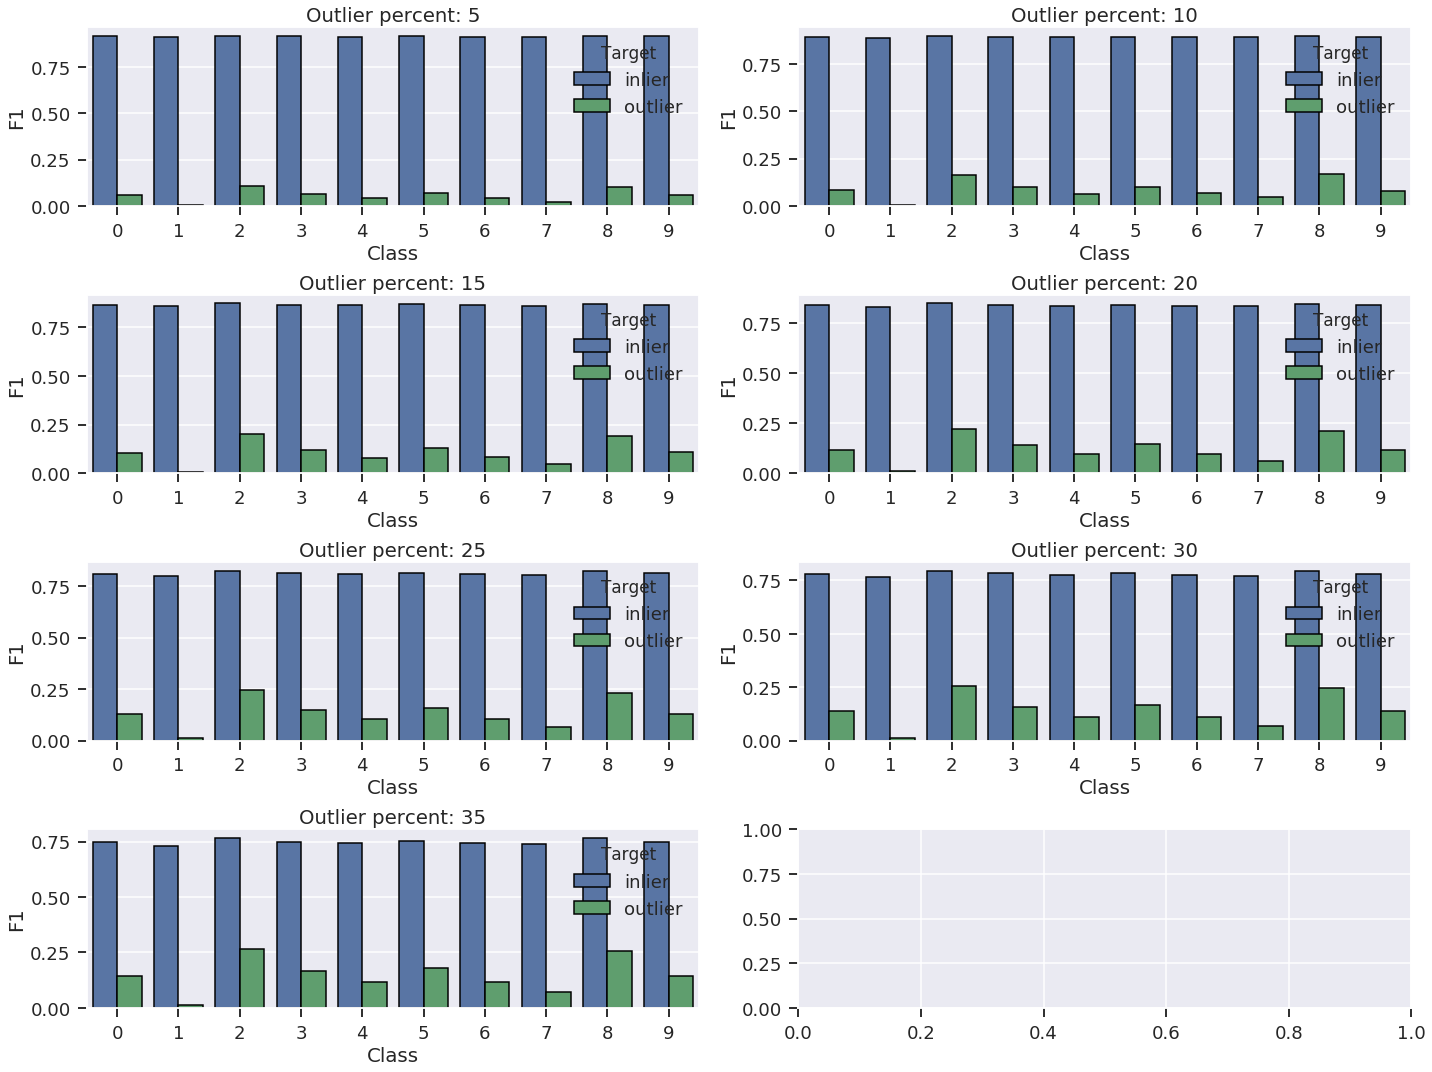




MNIST-AUROC


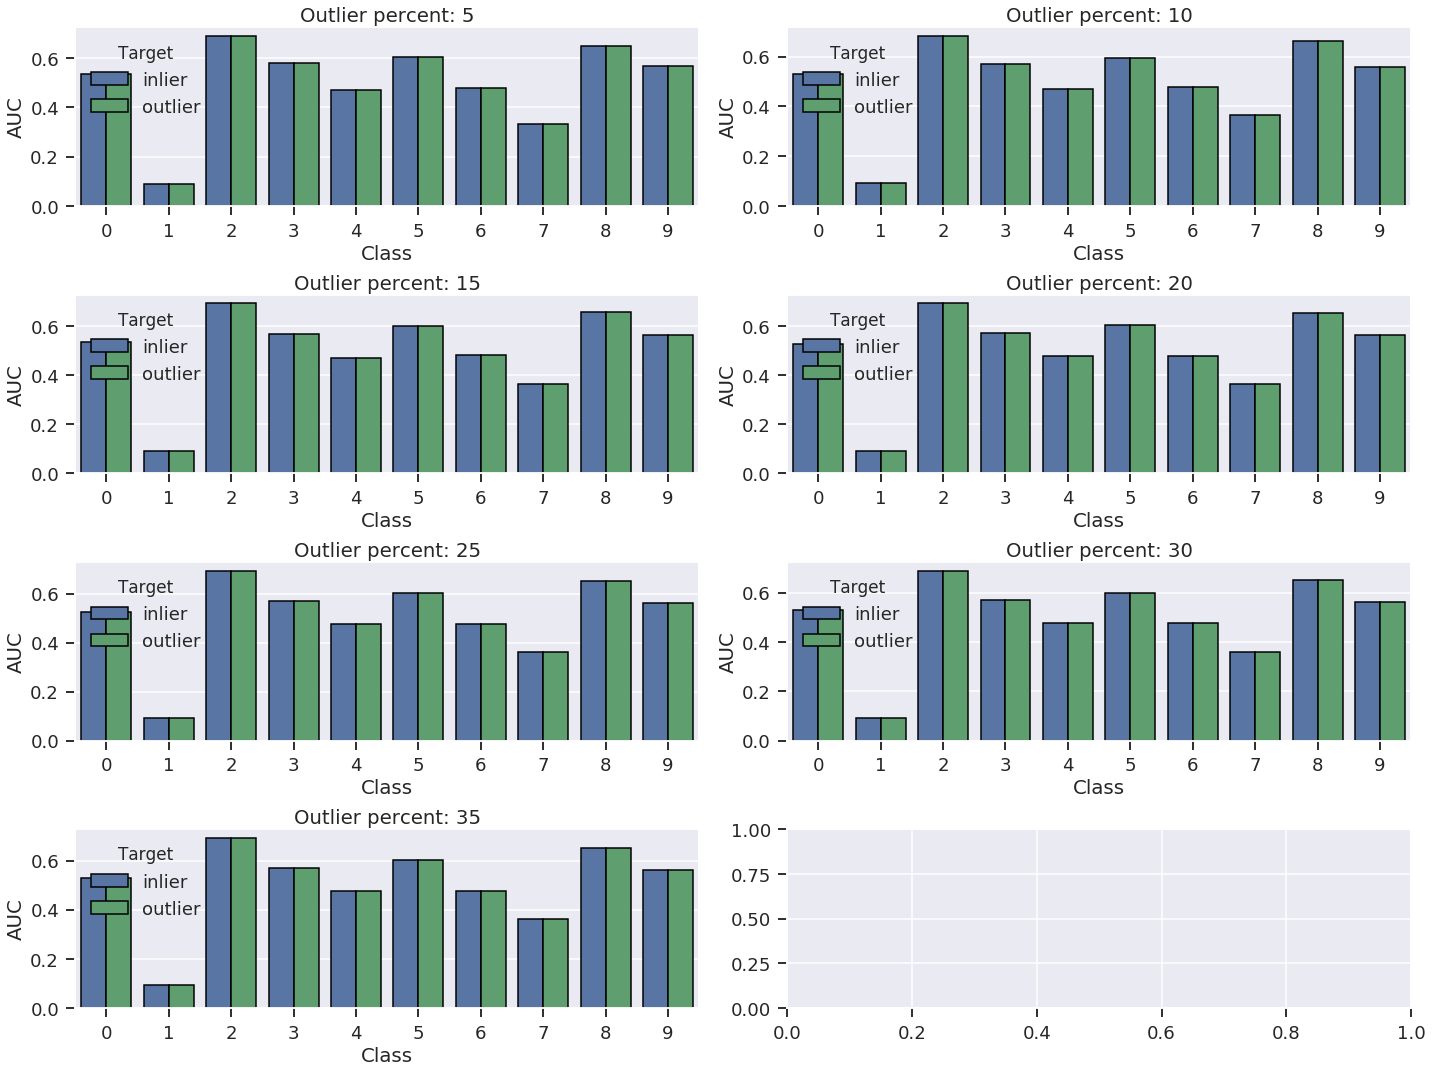




MNIST-AUPRC(auprin)


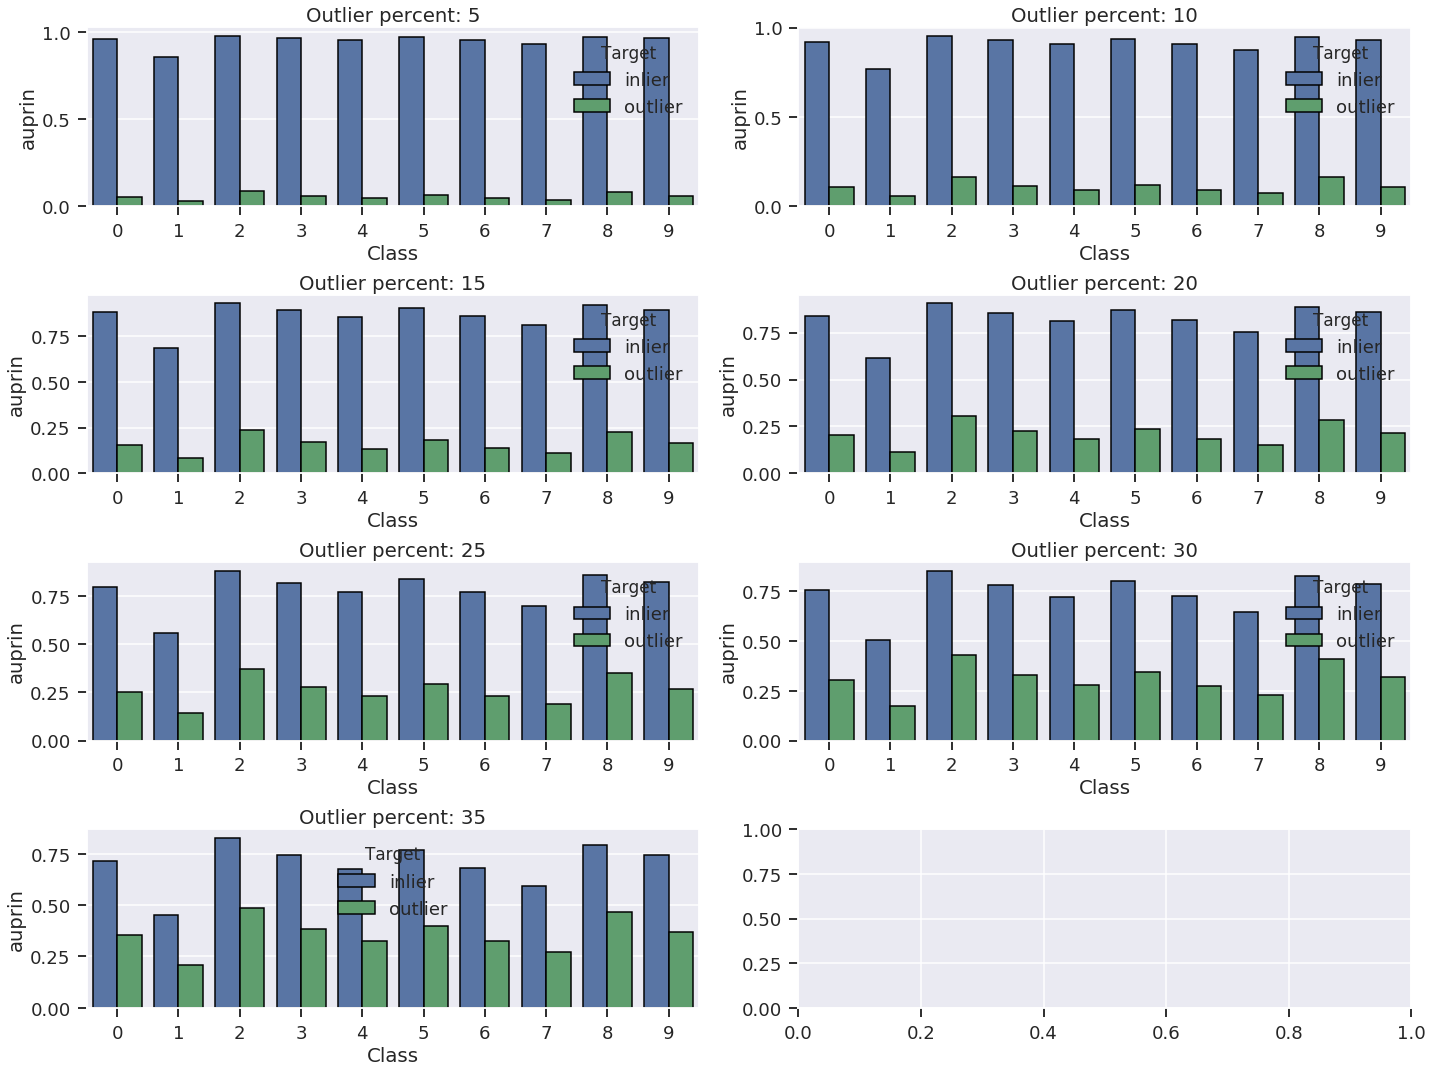




MNIST-AUPRC(auprout)


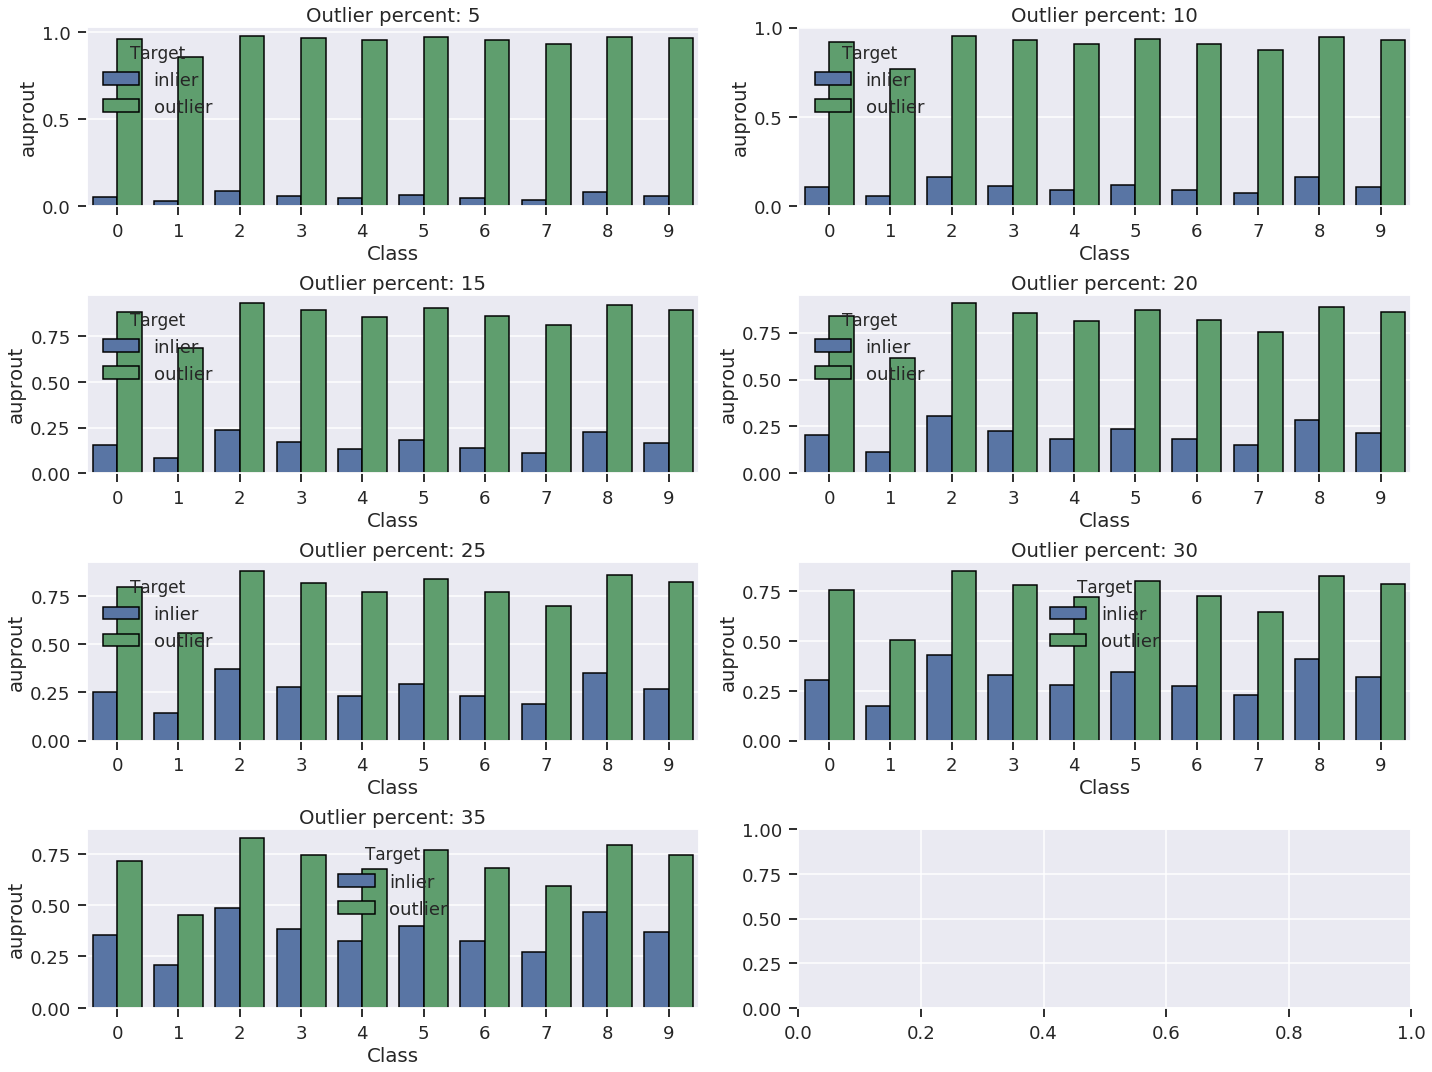

In [40]:
df = get_data_df("test_fold_{}")

# 논문 결과랑 비교하기 => 거의 비슷
df.groupby(["Outlier Percent", "Target"]).agg({"F1":np.mean,})

# Test_fold 끼리는 mean
_df = df.groupby(["Class", "Outlier Percent", "Target"]).agg({
    "F1":np.mean,
    "AUC":np.mean,
    "auprin":np.mean,
    "auprout":np.mean,
}).reset_index()

print("MNIST-F1")
plot_result(_df, "F1")
print("MNIST-AUROC")
plot_result(_df, "AUC")
print("MNIST-AUPRC(auprin)")
plot_result(_df, "auprin")
print("MNIST-AUPRC(auprout)")
plot_result(_df, "auprout")

In [41]:
_df[(_df['Target'] == "outlier")]['AUC'].mean()
_df[(_df['Target'] == "outlier")]['AUC'].std()

0.5006107293512462

0.16508651947259617

In [168]:
_df[(_df['Target'] == "outlier")].groupby('Outlier Percent').agg(
    {
        "auprin":['mean', 'std'],
        "AUC":['mean', 'std'],
    }
)

auprin           AUC       
                  mean    std   mean    std
Outlier Percent                            
10              0.8518 0.0842 0.9719 0.0217
20              0.9174 0.0549 0.9714 0.0247
30              0.9434 0.0360 0.9710 0.0224
40              0.9604 0.0277 0.9714 0.0238
50              0.9713 0.0195 0.9709 0.0226

F1
Outlier Percent Target        
5               inlier  0.9523
                outlier 0.1269
10              inlier  0.9296
                outlier 0.1619
15              inlier  0.9049
                outlier 0.1829
20              inlier  0.8791
                outlier 0.1949
25              inlier  0.8519
                outlier 0.2021
30              inlier  0.8227
                outlier 0.2071
35              inlier  0.7911
                outlier 0.2110

AUC
Outlier Percent Target        
5               inlier  0.6914
                outlier 0.6914
10              inlier  0.6896
                outlier 0.6896
15              inlier  0.6917
                outlier 0.6917
20              inlier  0.6911
                outlier 0.6911
25              inlier  0.6915
                outlier 0.6915
30              inlier  0.6907
                outlier 0.6907
35              inlier  0.6907
                outlier 0.6907

FMNIST-F1


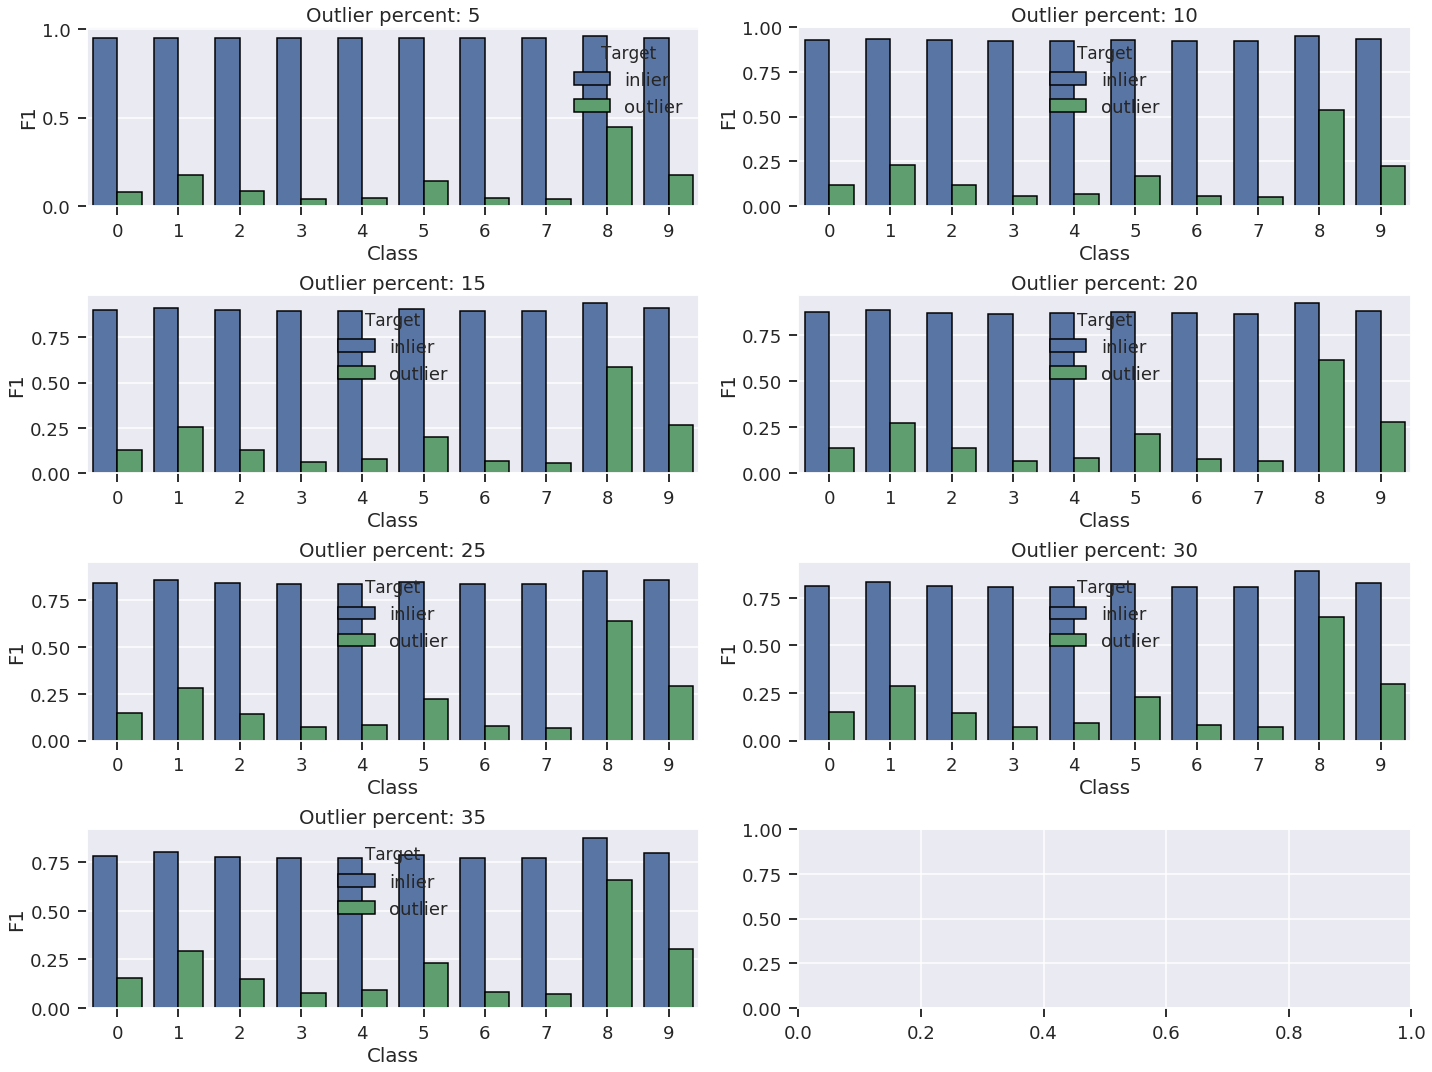




FMNIST-AUROC


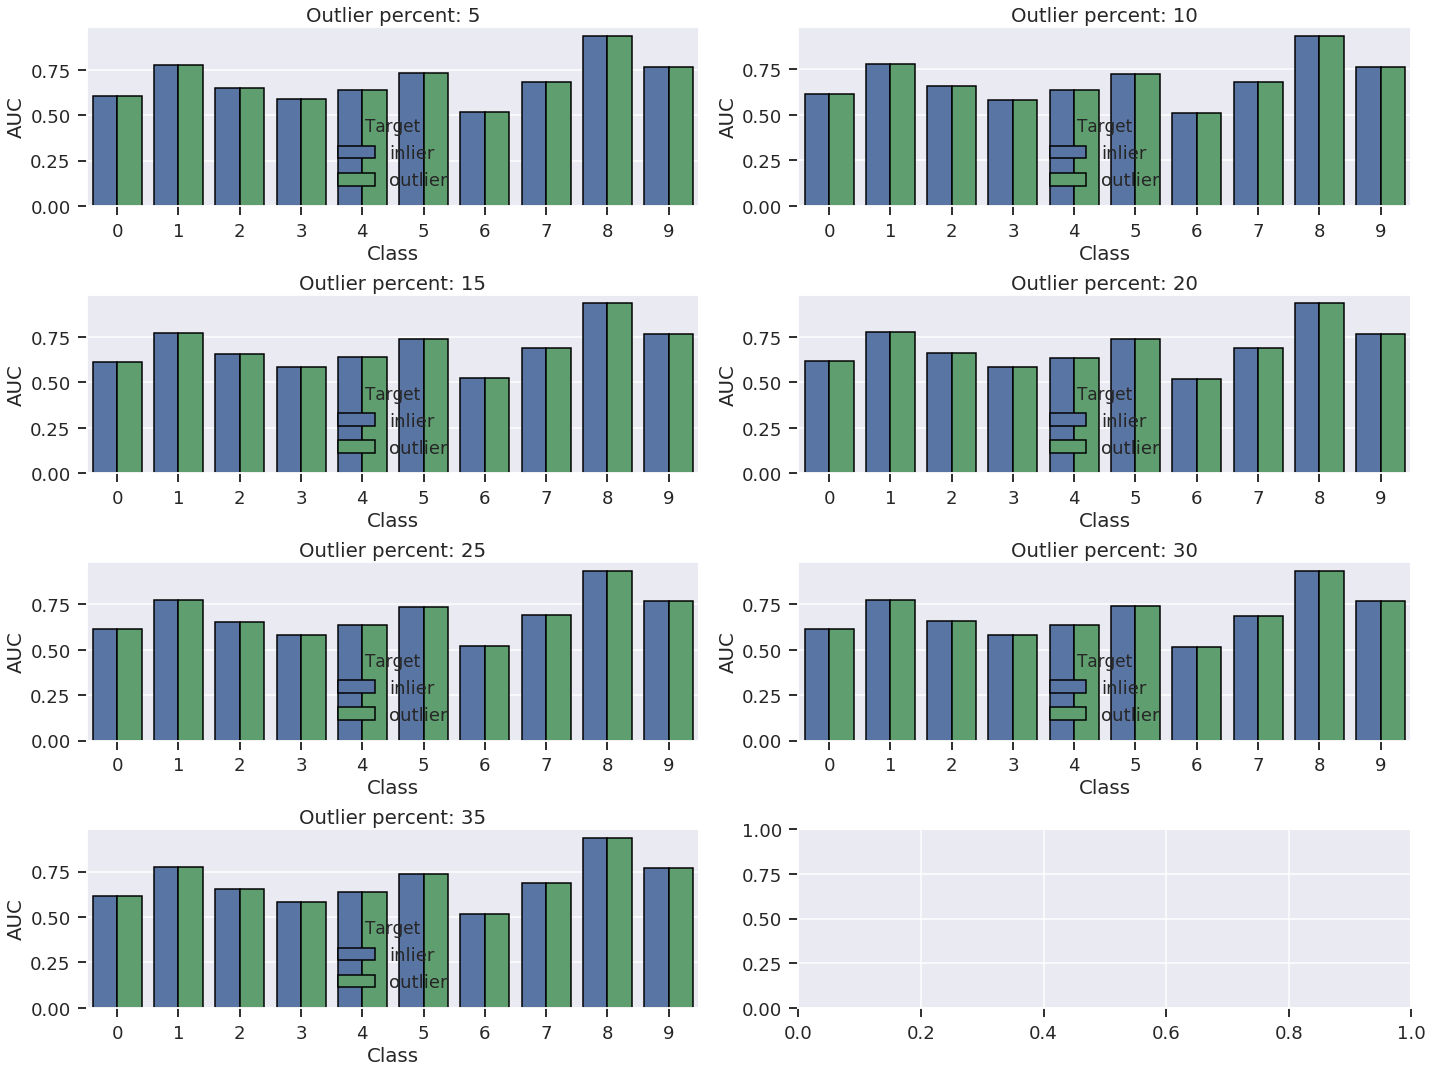




FMNIST-AUPRC(auprin)


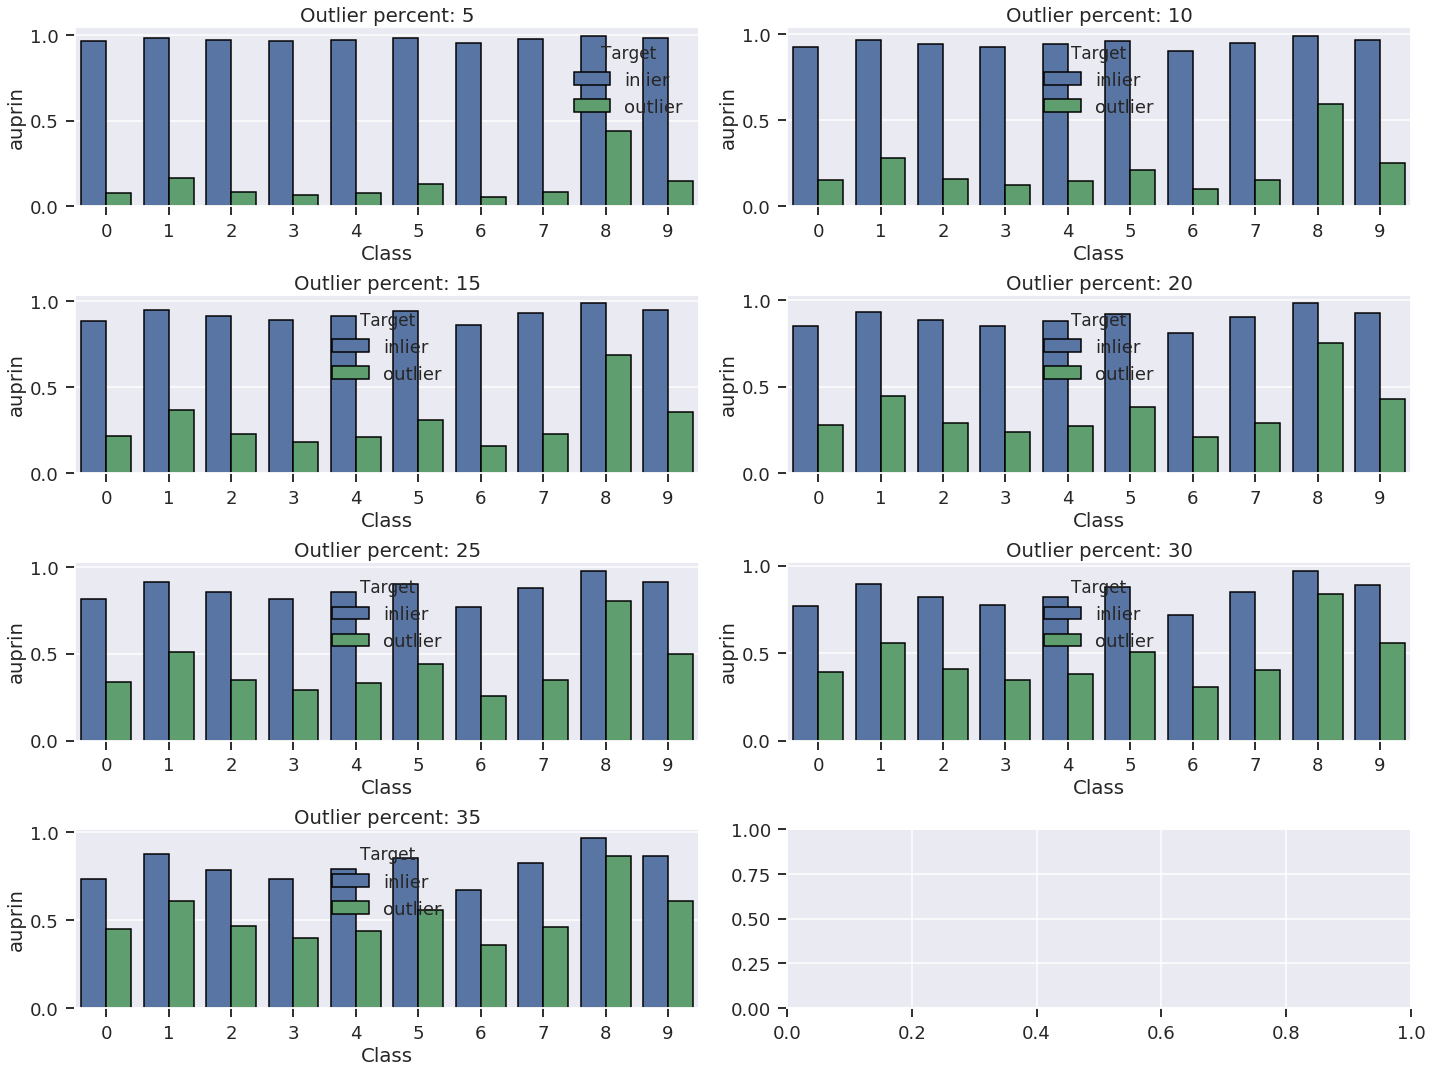

In [42]:
df = get_data_df("f_test_fold_{}")

# 논문 결과와 비교 -> 거의 비슷
df.groupby(["Outlier Percent", "Target"]).agg({"F1":np.mean,})
df.groupby(["Outlier Percent", "Target"]).agg({"AUC":np.mean,})

# Test_fold 끼리는 mean
_df = df.groupby(["Class", "Outlier Percent", "Target"]).agg({
    "F1":np.mean,
    "AUC":np.mean,
    "auprin":np.mean,
    "auprout":np.mean,
}).reset_index()

print("FMNIST-F1")
plot_result(_df, "F1")
print("FMNIST-AUROC")
plot_result(_df, "AUC")
print("FMNIST-AUPRC(auprin)")
plot_result(_df, "auprin")

In [43]:
_df[(_df['Target'] == "outlier")]['AUC'].mean()
_df[(_df['Target'] == "outlier")]['AUC'].std()

0.6909576661507566

0.1133417891180822

In [184]:
_df[(_df['Target'] == "outlier")].groupby('Class').agg(
    {
        "auprin":['mean', 'std'],
        "AUC":['mean', 'std'],
    }
)
_df[(_df['Target'] == "outlier")].groupby('Outlier Percent').agg(
    {
        "auprin":['mean', 'std'],
        "AUC":['mean', 'std'],
    }
)

auprin           AUC       
        mean    std   mean    std
Class                            
0     0.7735 0.1297 0.9048 0.0018
1     0.9436 0.0424 0.9839 0.0004
2     0.7575 0.1341 0.8729 0.0065
3     0.8637 0.0868 0.9361 0.0042
4     0.8326 0.0896 0.9070 0.0031
5     0.8464 0.0735 0.9044 0.0052
6     0.6748 0.1522 0.7883 0.0199
7     0.9587 0.0257 0.9807 0.0009
8     0.7650 0.1360 0.9062 0.0034
9     0.9564 0.0269 0.9798 0.0013

auprin           AUC       
                  mean    std   mean    std
Outlier Percent                            
10              0.6983 0.1684 0.9130 0.0682
20              0.8035 0.1139 0.9150 0.0574
30              0.8644 0.0830 0.9198 0.0557
40              0.8973 0.0655 0.9177 0.0573
50              0.9227 0.0519 0.9165 0.0597

# Quantile  (MRX)

MNIST-F1
Threshold Percent :0.5


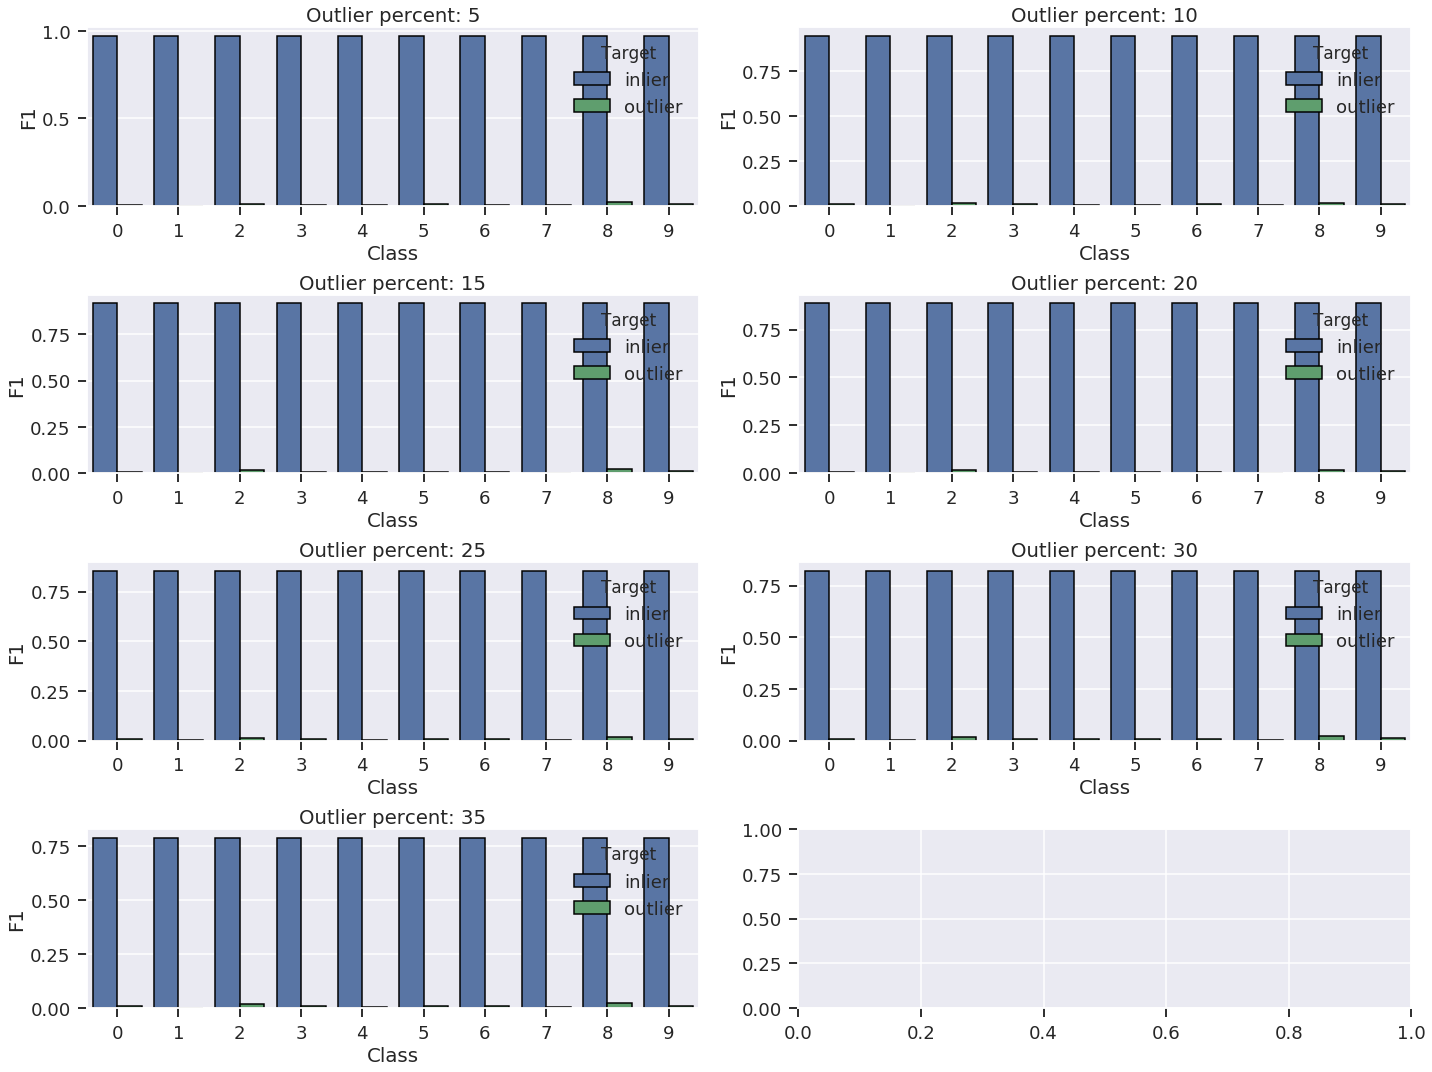




Threshold Percent :2


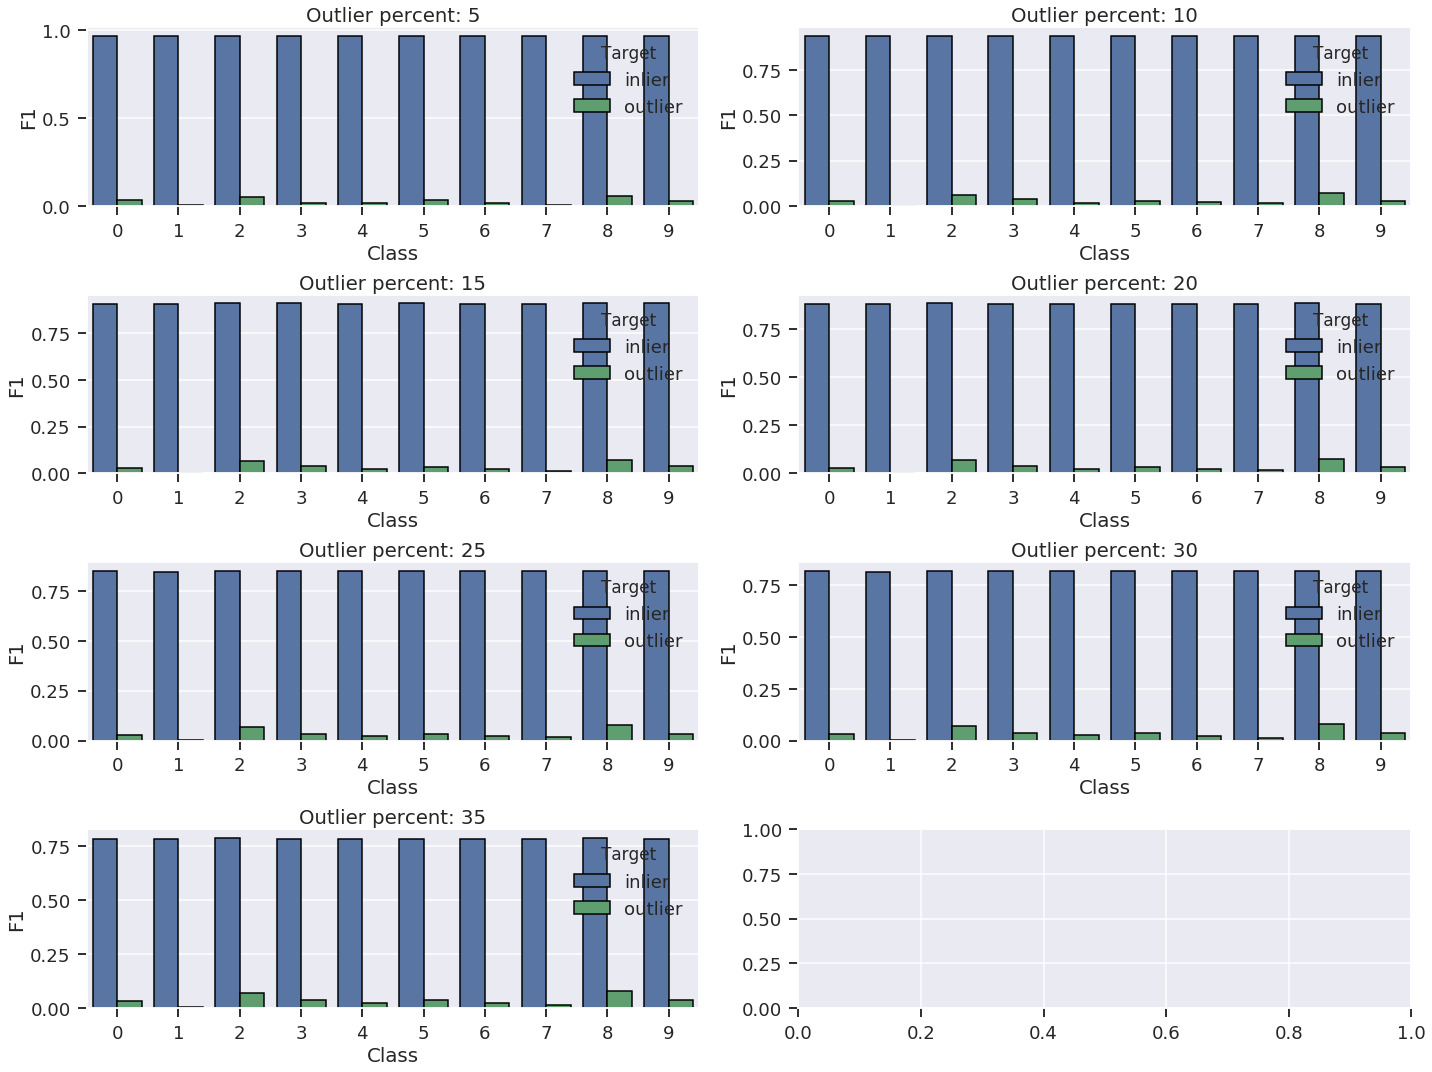




Threshold Percent :3.5


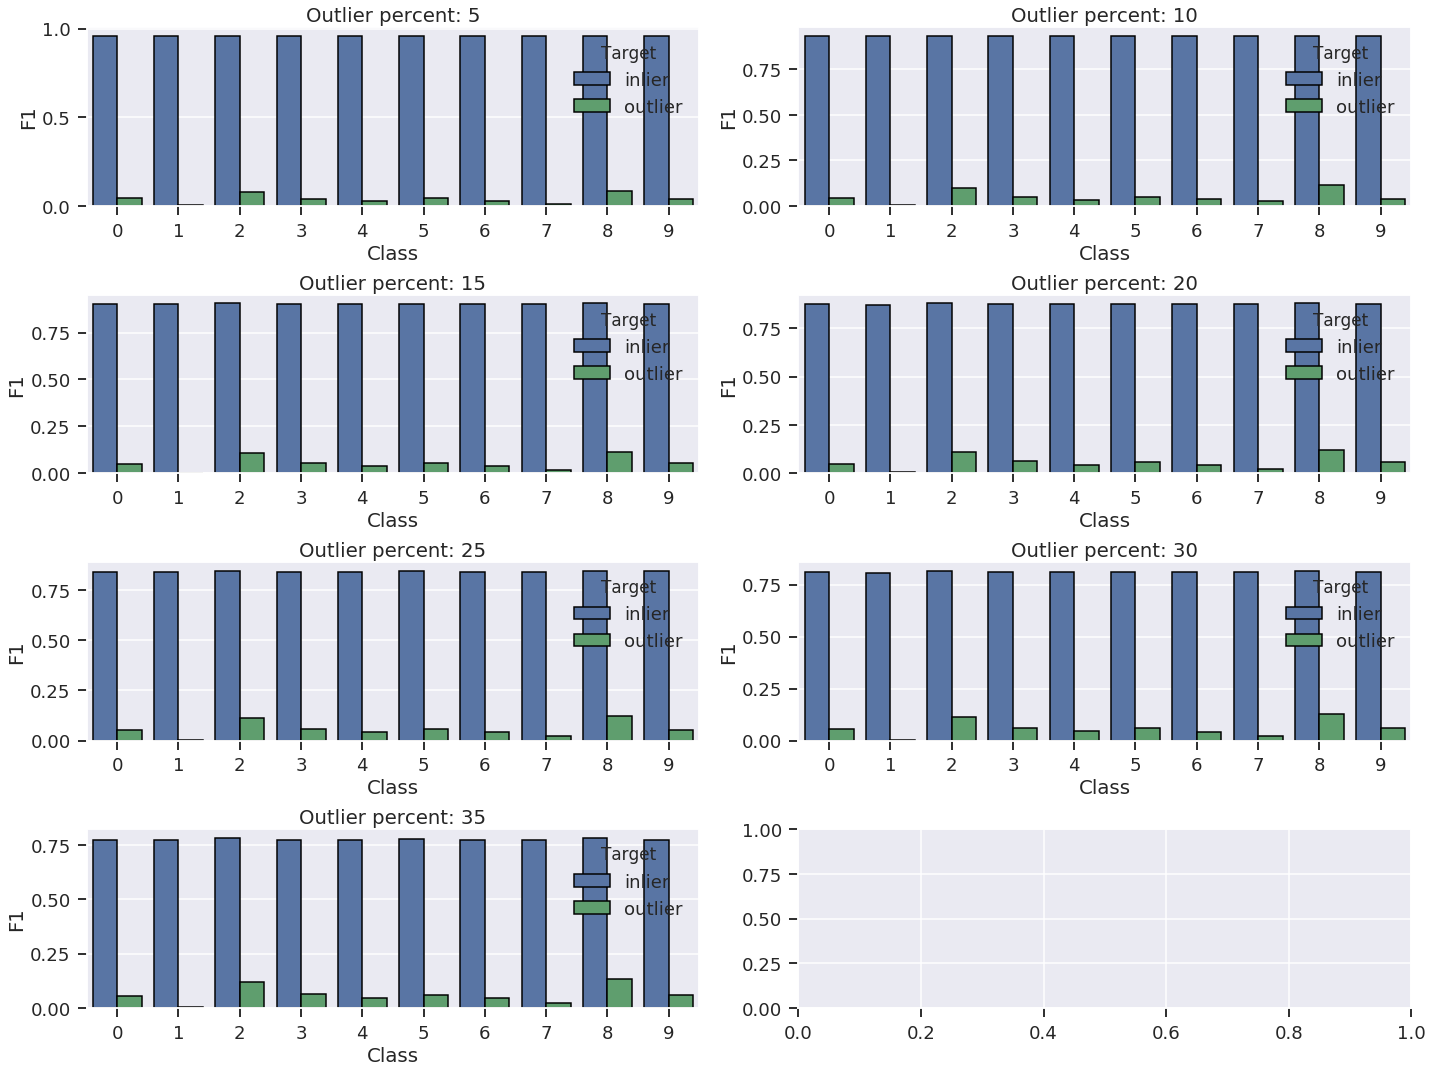




Threshold Percent :5


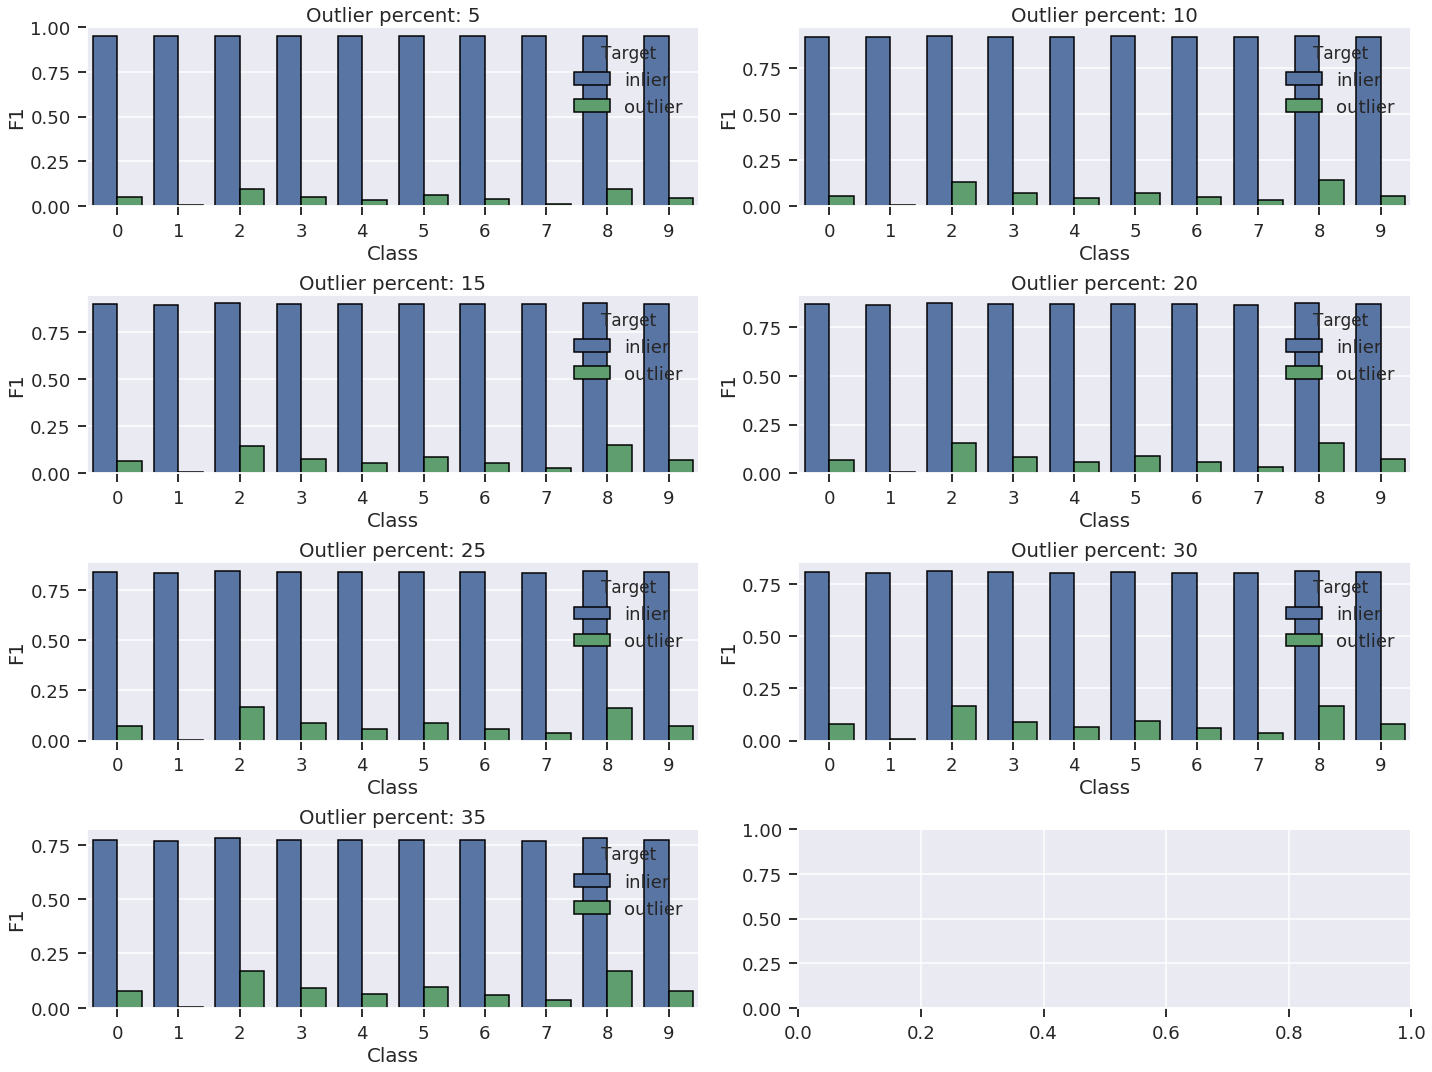




Threshold Percent :6.5


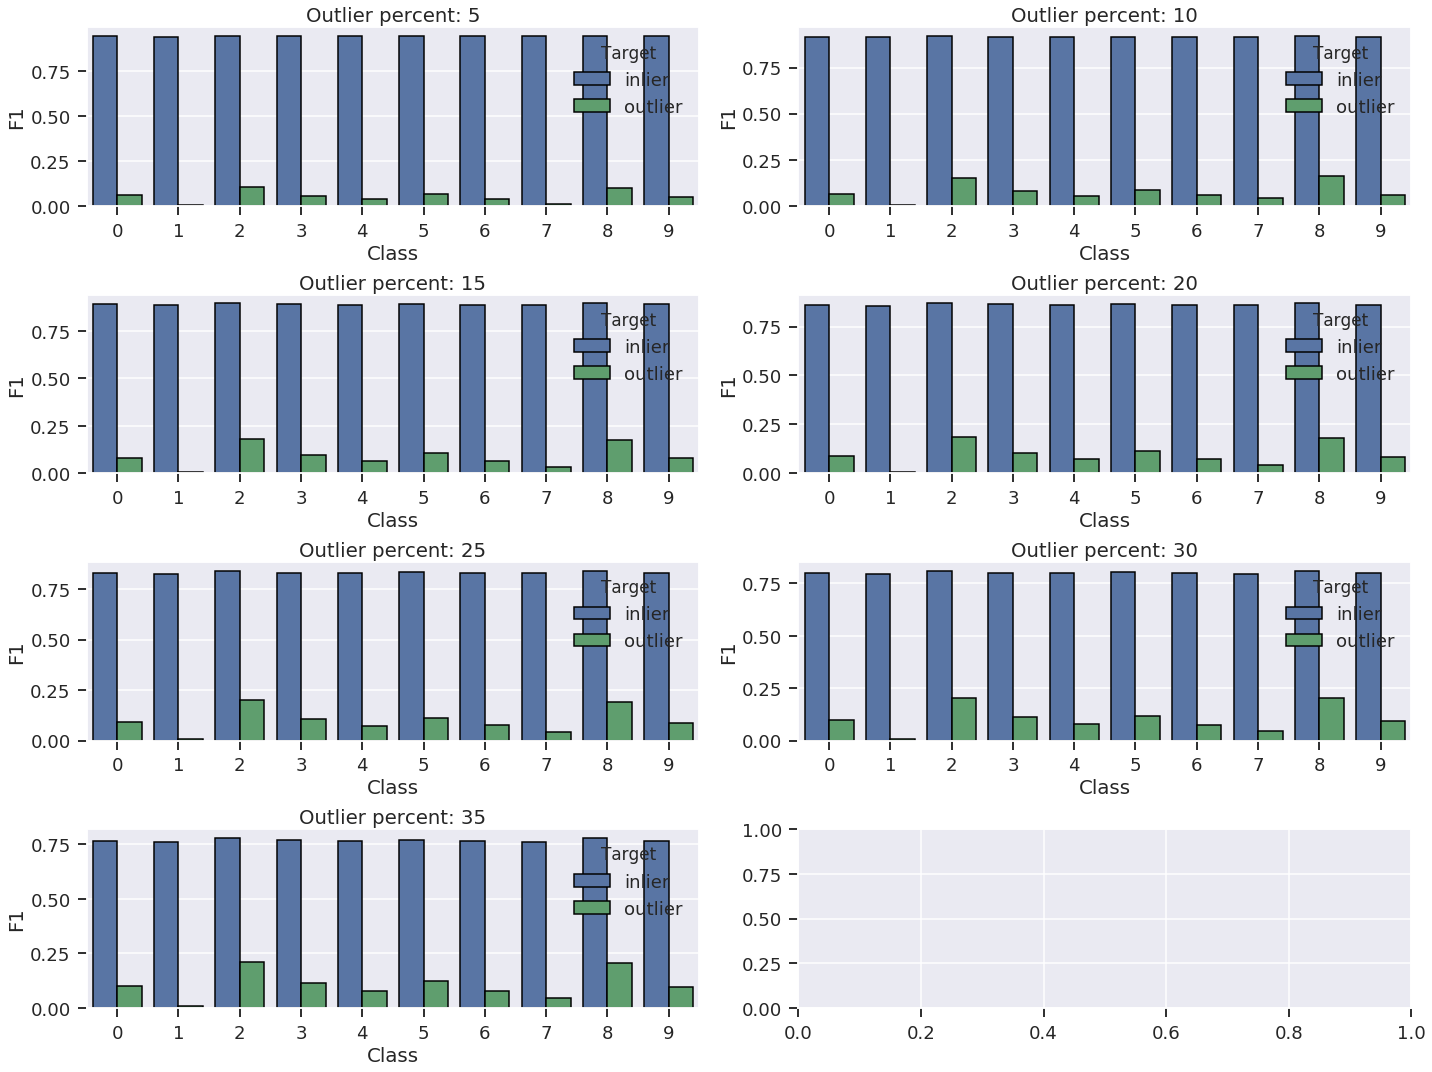




Threshold Percent :8


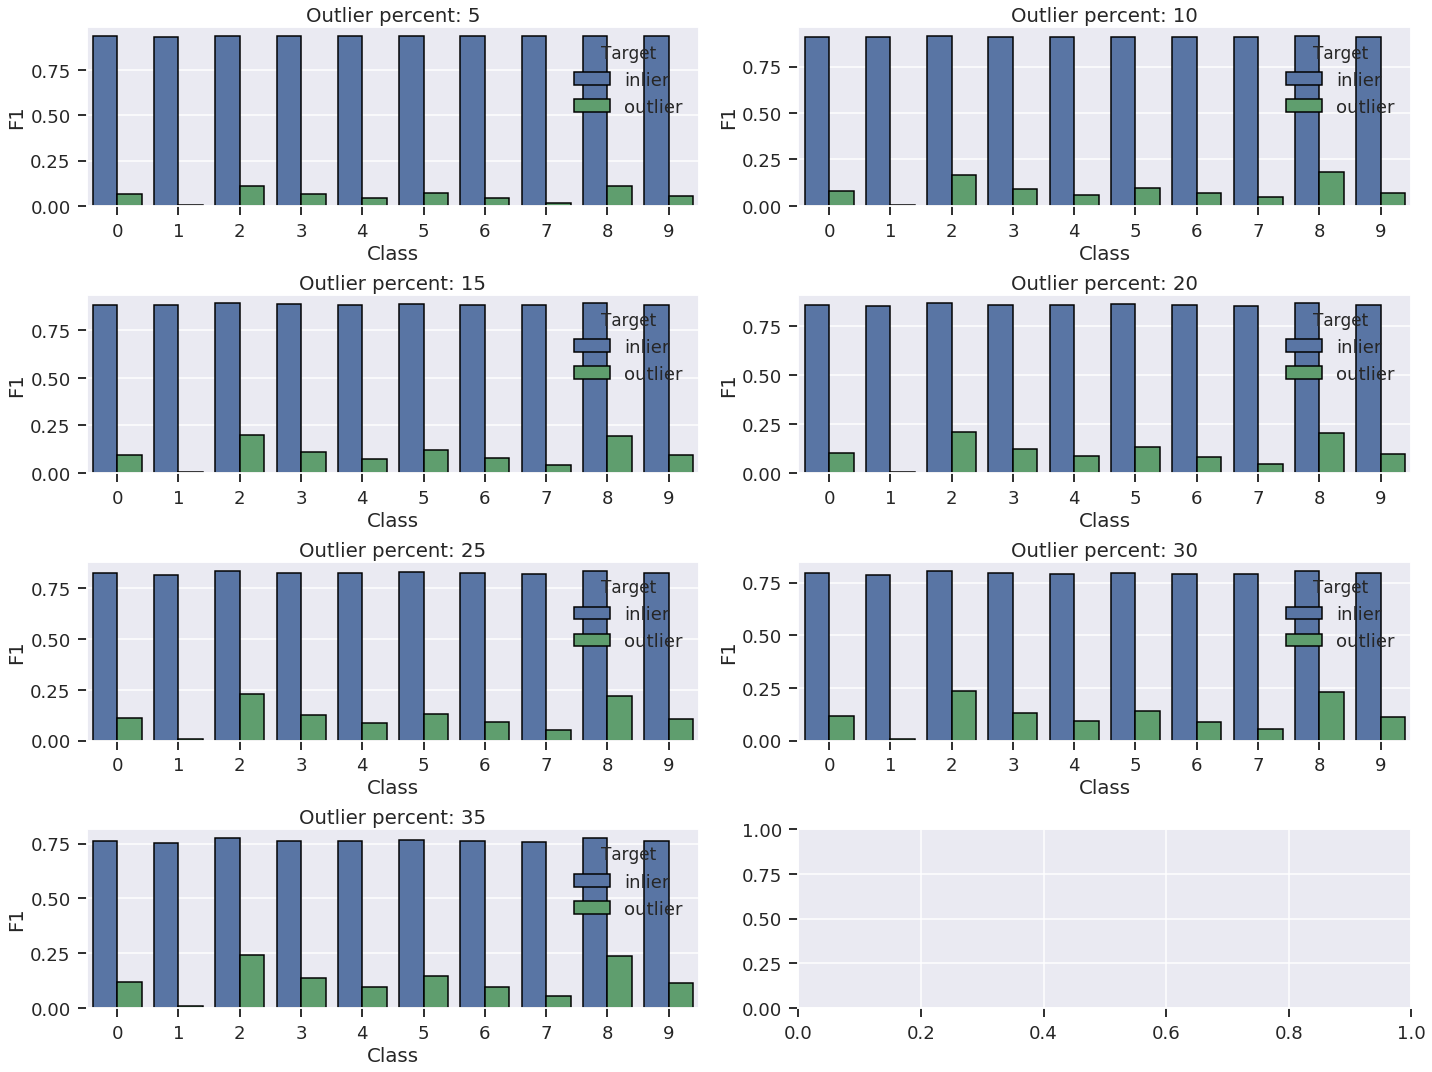




Threshold Percent :9.5


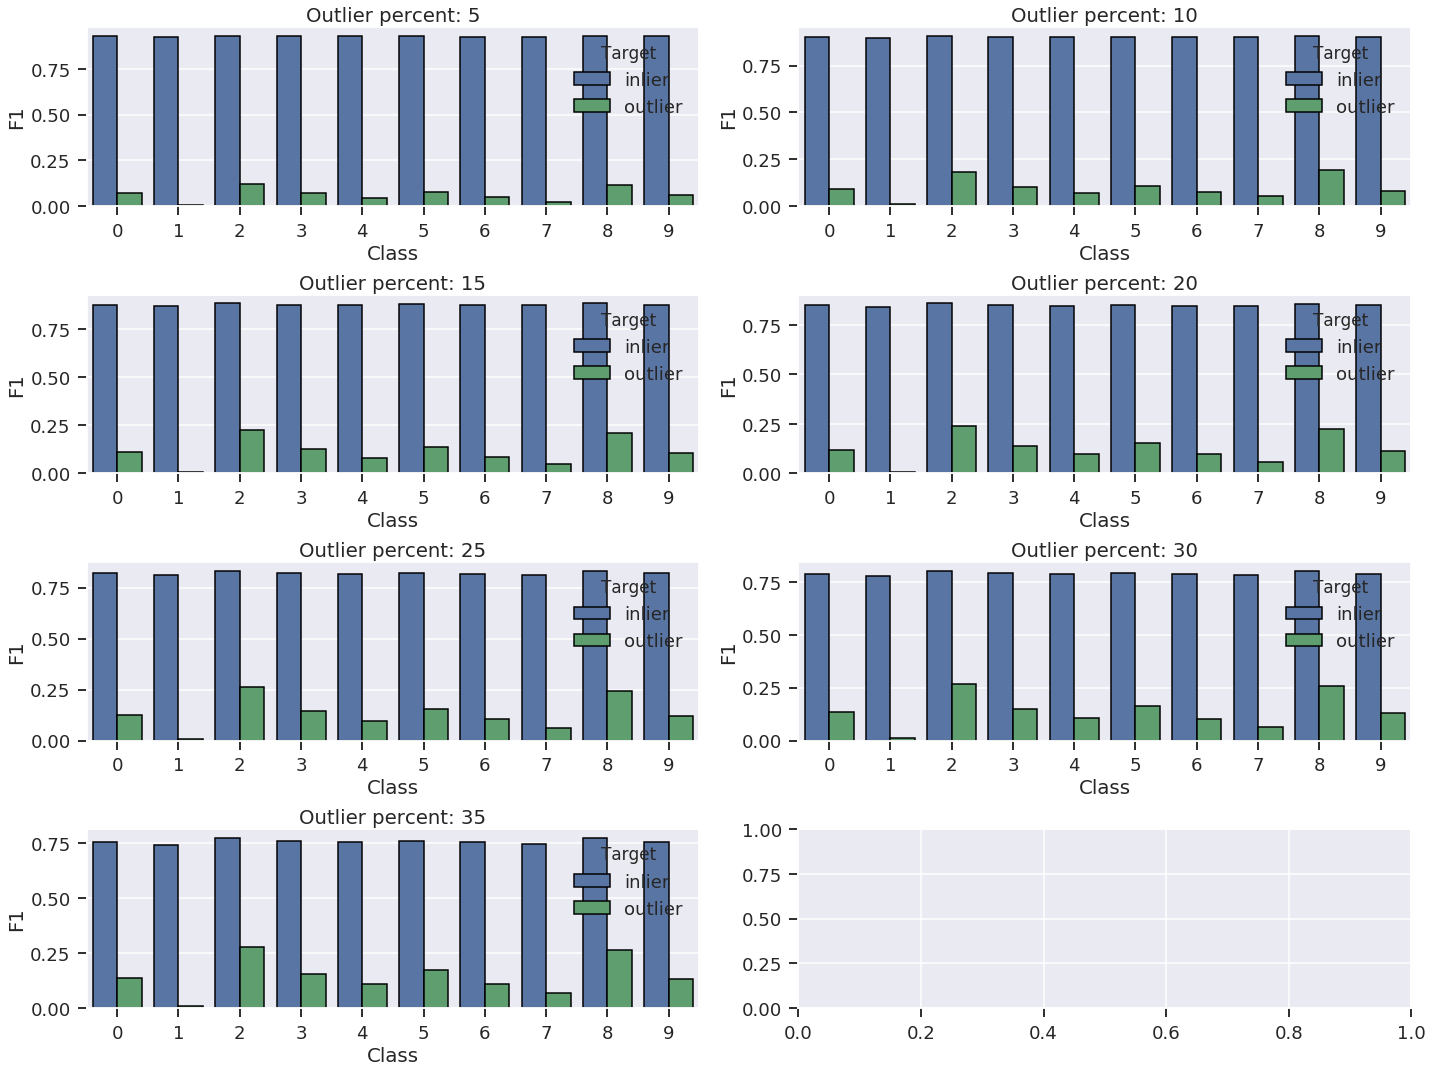




MNIST-AUROC


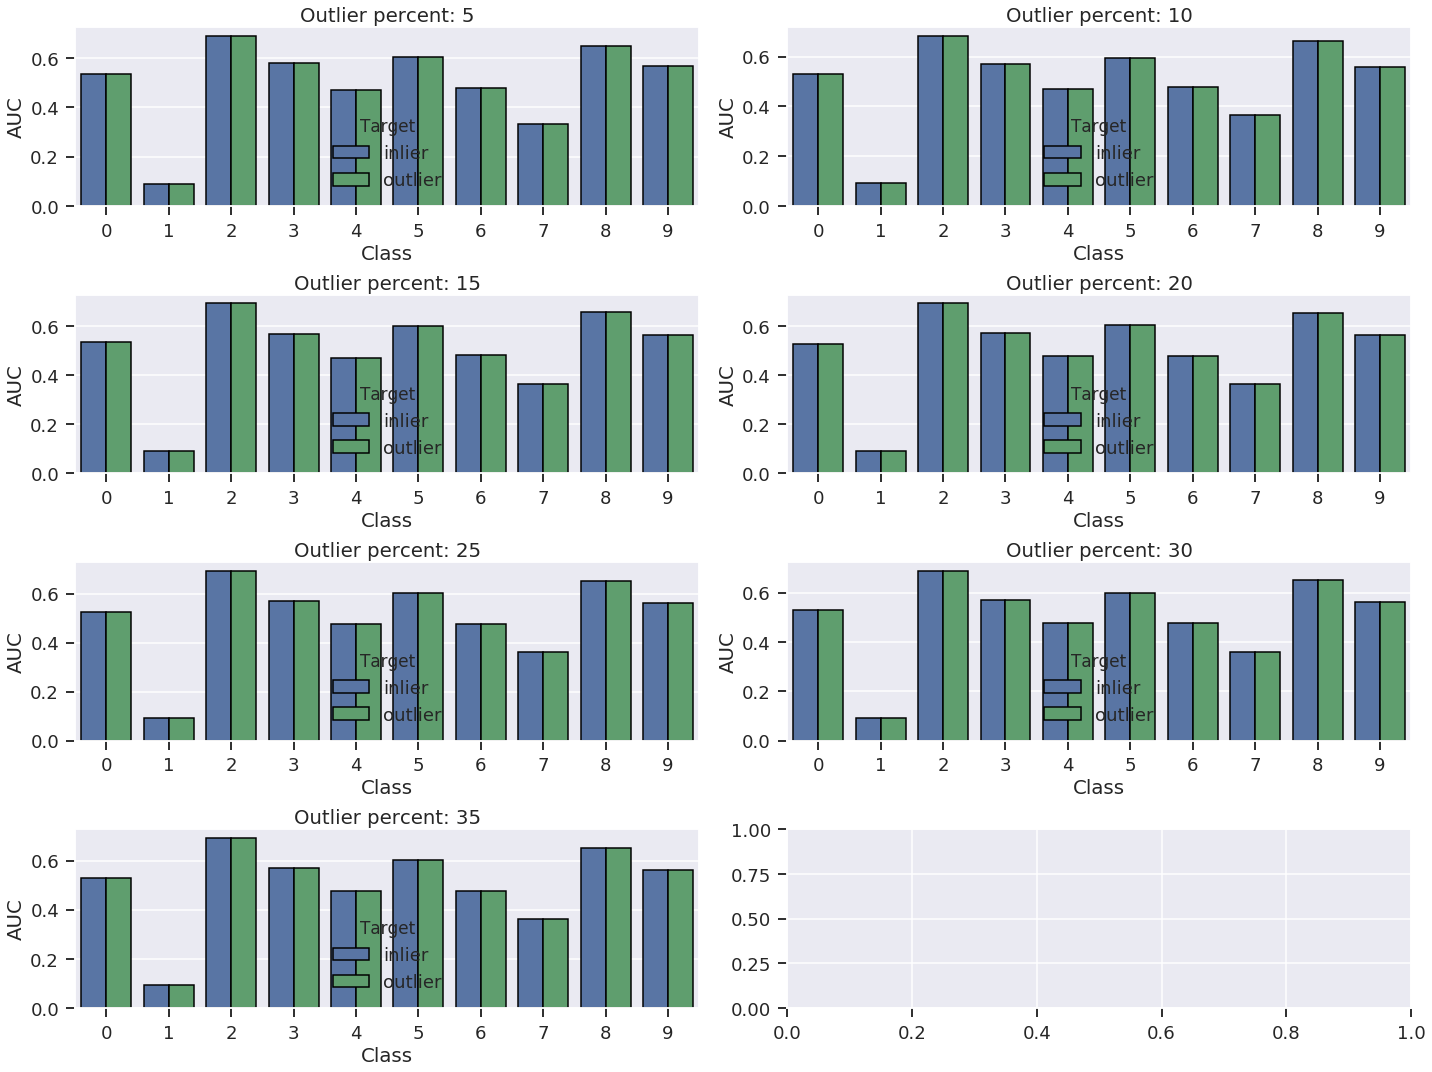




MNIST-AUPRC(auprin)


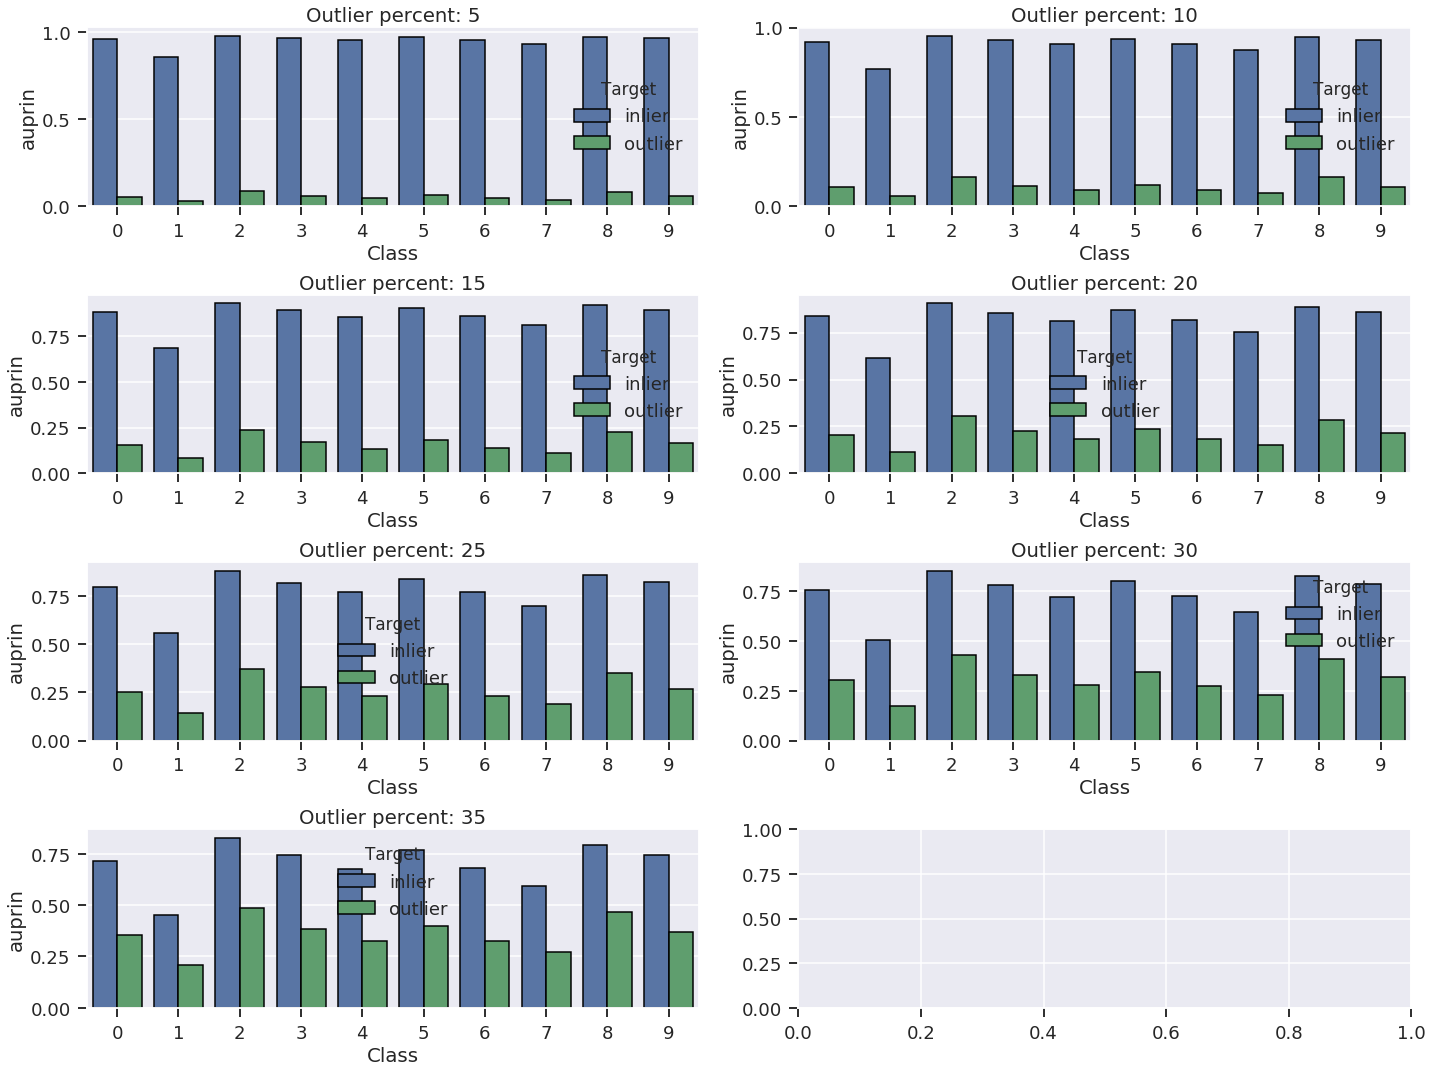

In [228]:
df = get_data_df("test_fold_{}")

# F1만 Threshold percent 관여 
_df = df.groupby(["Class", "Outlier Percent", "Threshold Percent", "Target"]).agg({
    "F1":np.mean,
    "AUC":np.mean,
    "auprin":np.mean,
    "auprout":np.mean,
}).reset_index()

# F1만 Threshold percent 관여 
thres_percents = ['0.5', '2', '3.5', '5', '6.5', '8', '9.5']

print("MNIST-F1")
for thres in thres_percents:
    print("Threshold Percent :{}".format(thres))
    plot_result(_df[_df['Threshold Percent'] == thres], "F1")
    
print("MNIST-AUROC")
plot_result(_df, "AUC")
print("MNIST-AUPRC(auprin)")
plot_result(_df, "auprin")

In [222]:
_df[(_df['Target'] == "outlier")].groupby('Outlier Percent').agg(
    {
        "auprin":['mean', 'std'],
        "AUC":['mean', 'std'],
    }
).loc[[10, 20, 30, 35], "auprin"]
# _df[(_df['Target'] == "outlier")  & (_df['Outlier Percent'] == 35)].groupby('Class').agg(
#     {
#         "auprin":['mean', 'std'],
#         "AUC":['mean', 'std'],
#     }
# )
# _df[(_df['Target'] == "outlier")  & (_df['Outlier Percent'] == 35)].groupby("Threshold Percent")['auprin'].mean()

,mean,std
Outlier Percent,,
10,0.1071,0.0322
20,0.2102,0.0559
30,0.3092,0.0729
35,0.3586,0.0796


FMNIST-F1
Threshold Percent :0.5


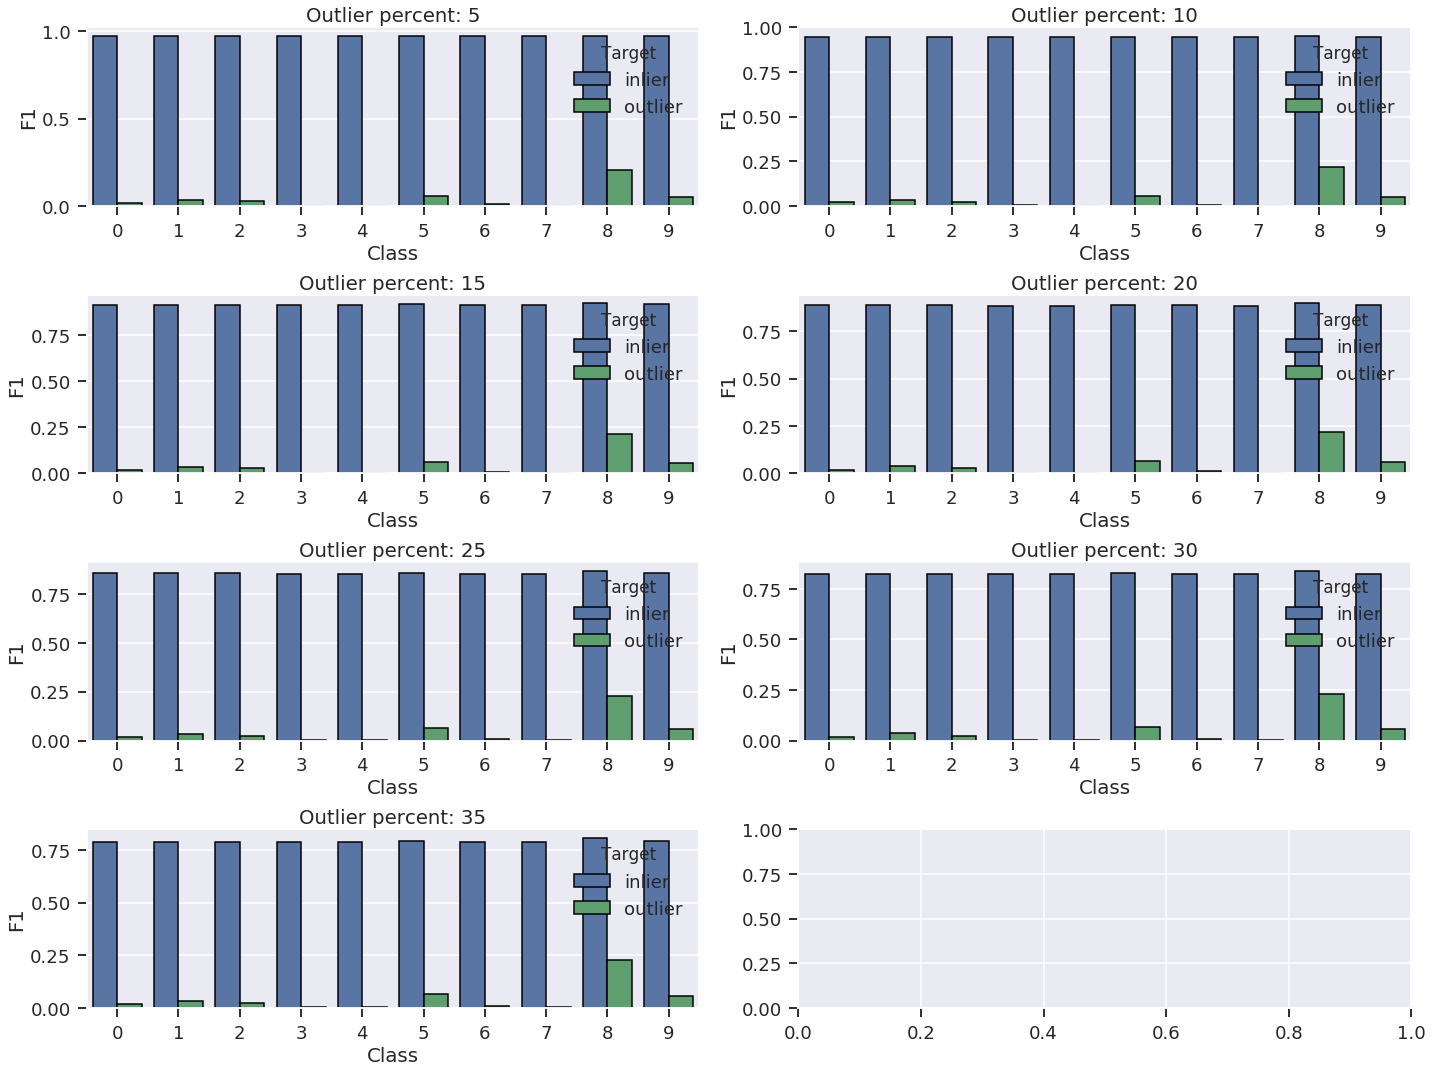




Threshold Percent :2


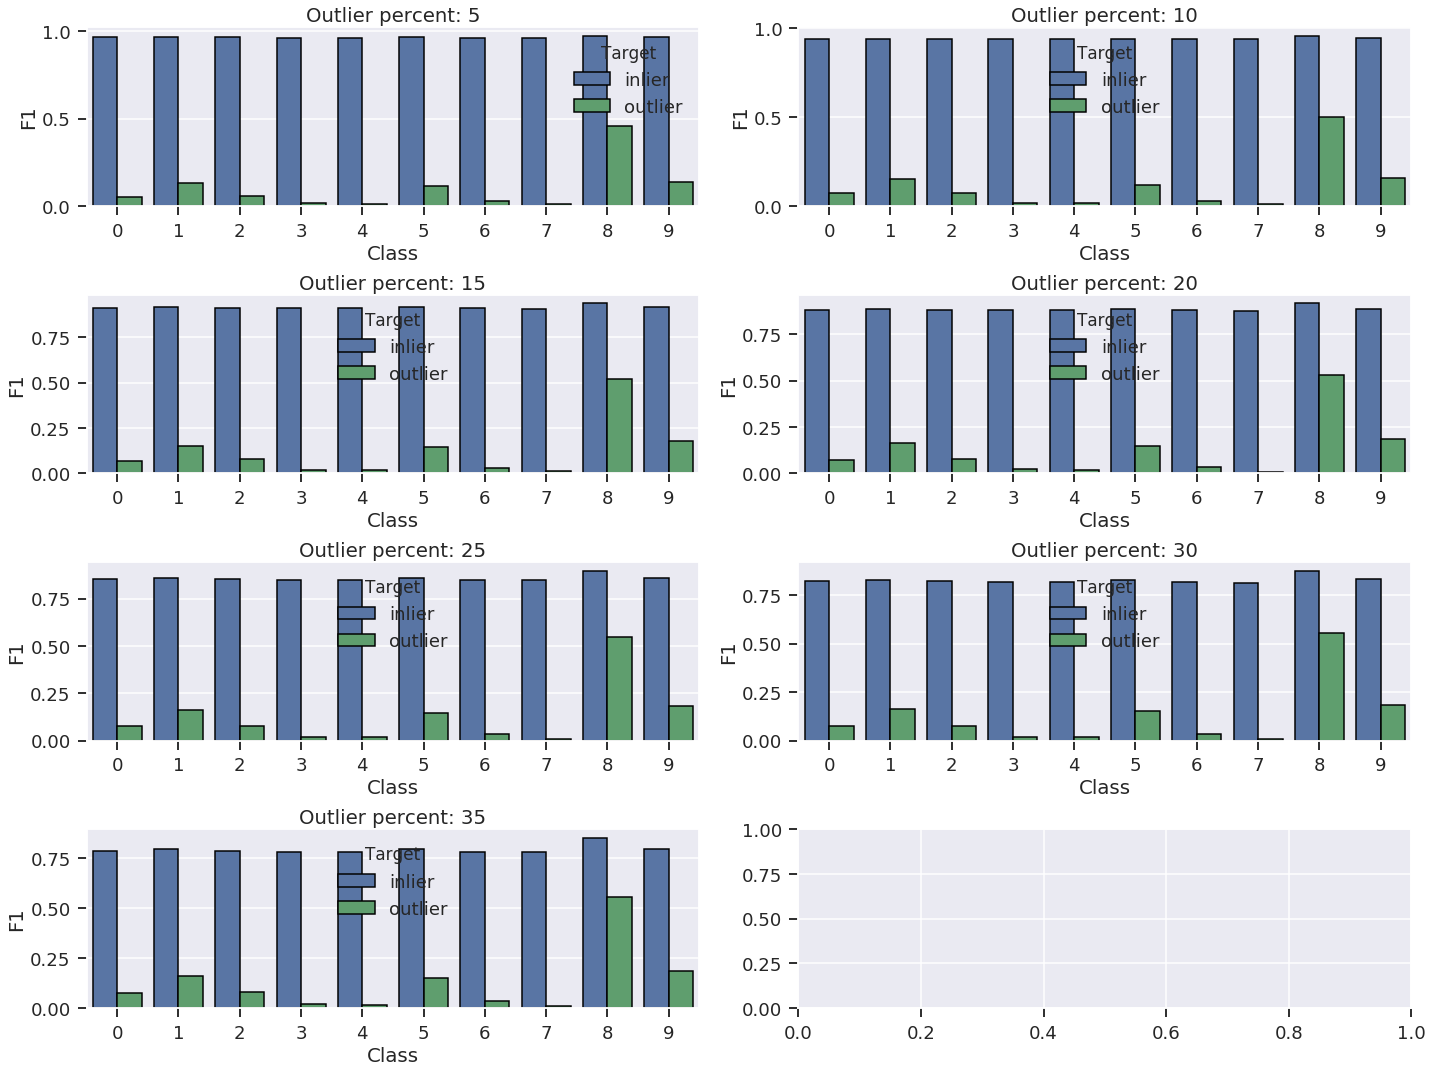




Threshold Percent :3.5


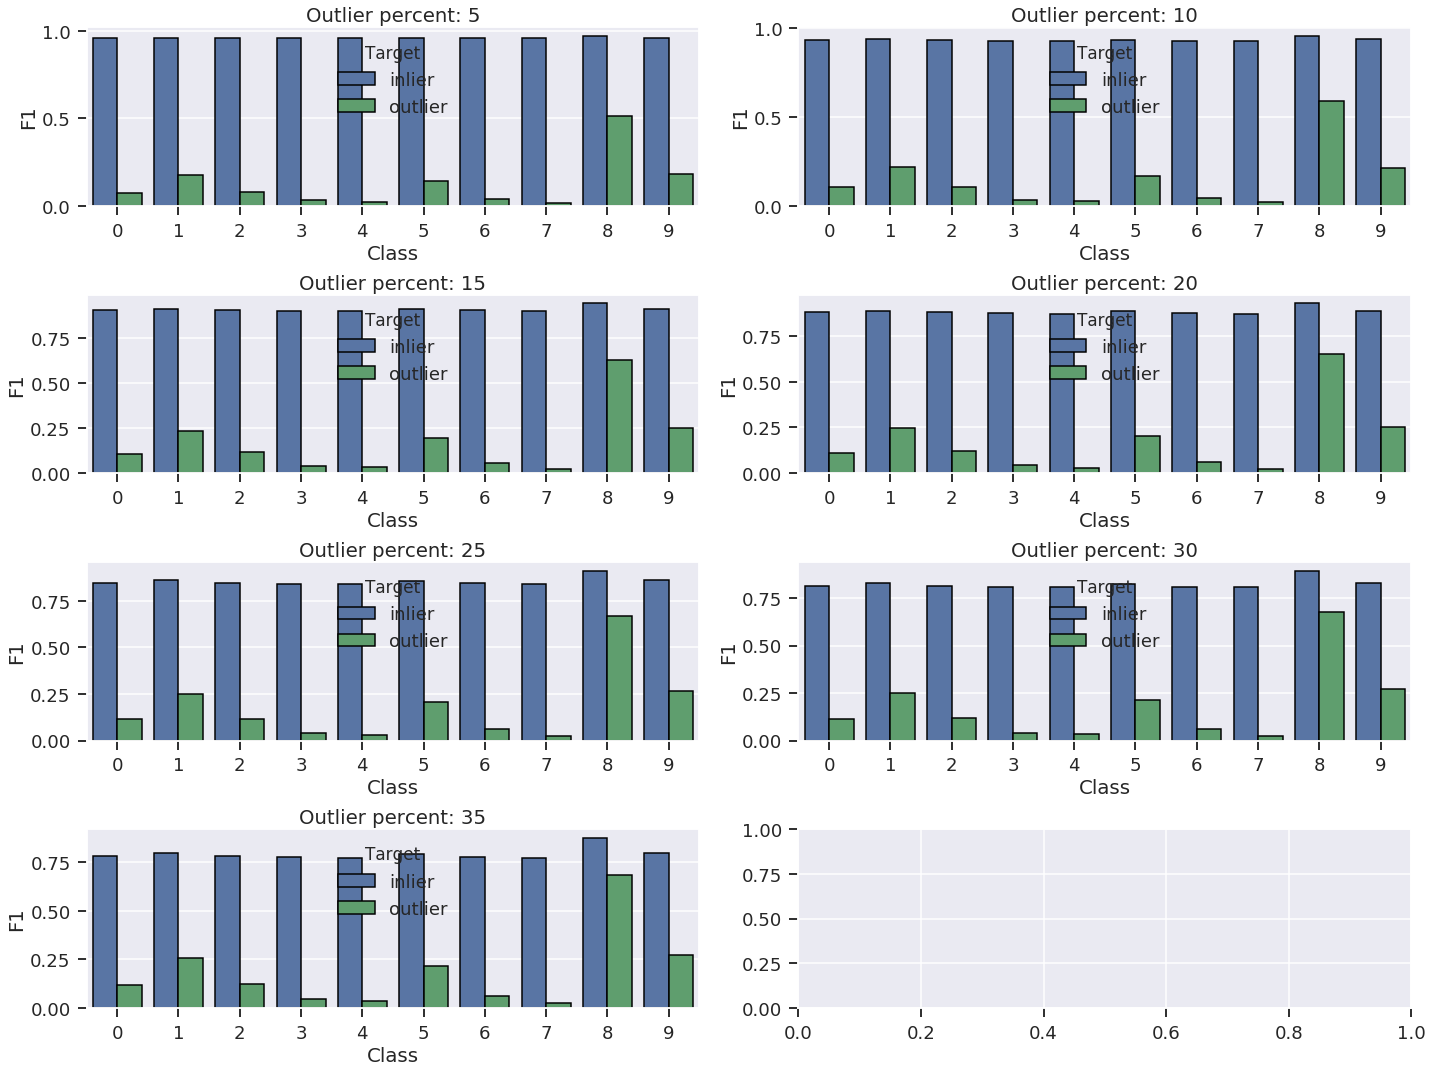




Threshold Percent :5


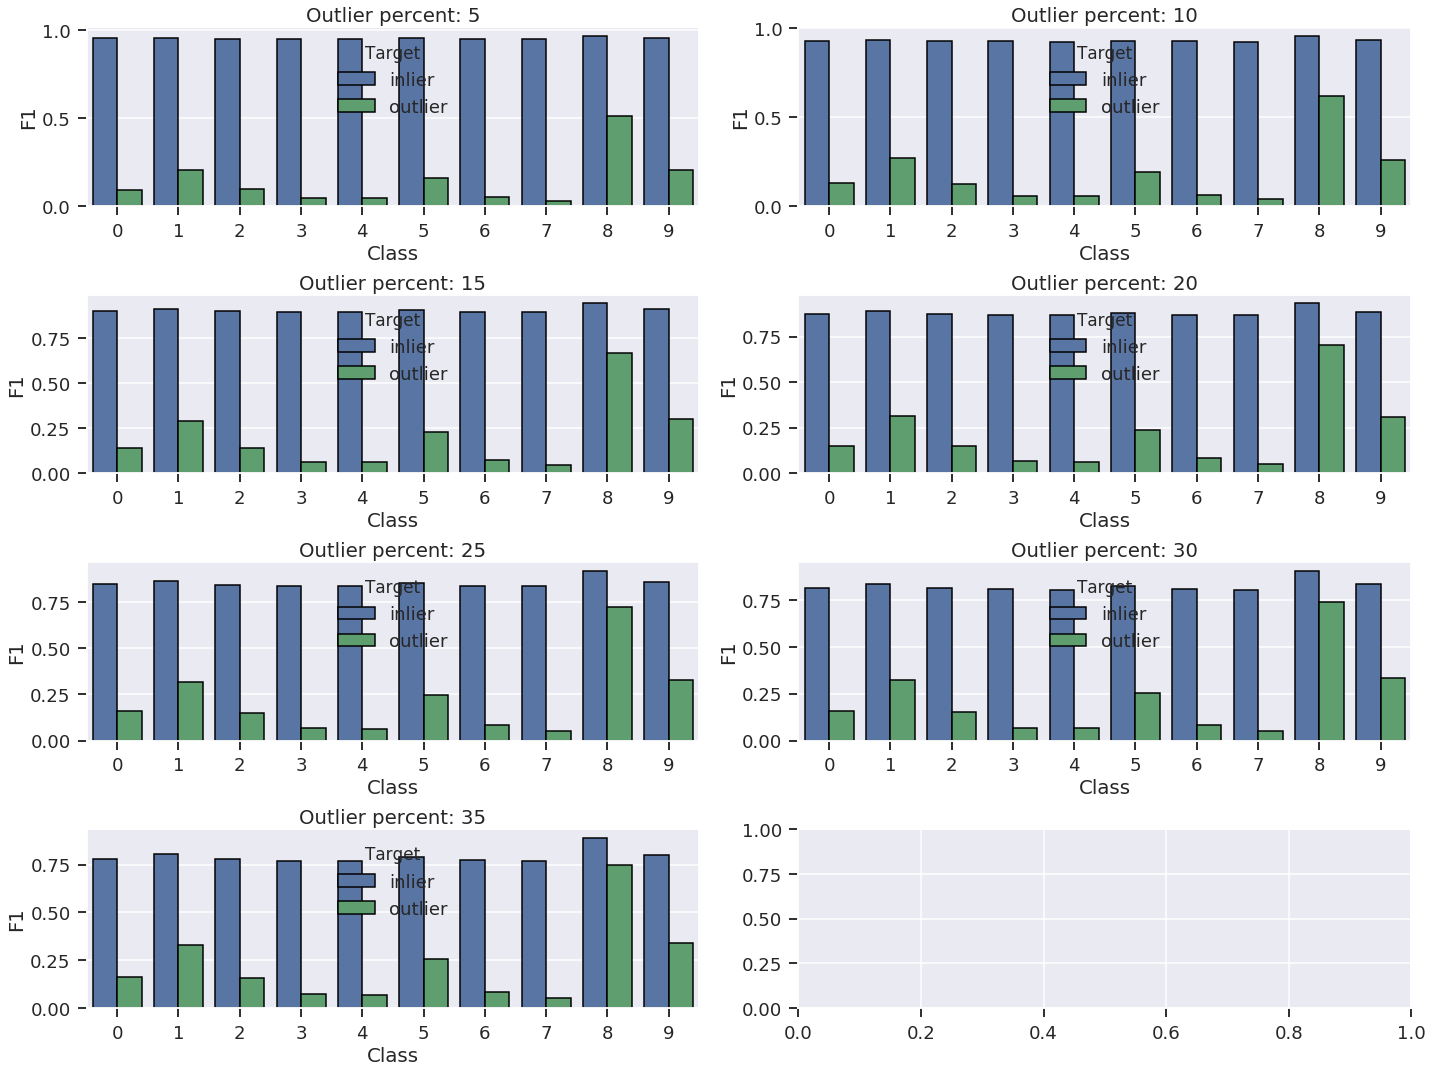




Threshold Percent :6.5


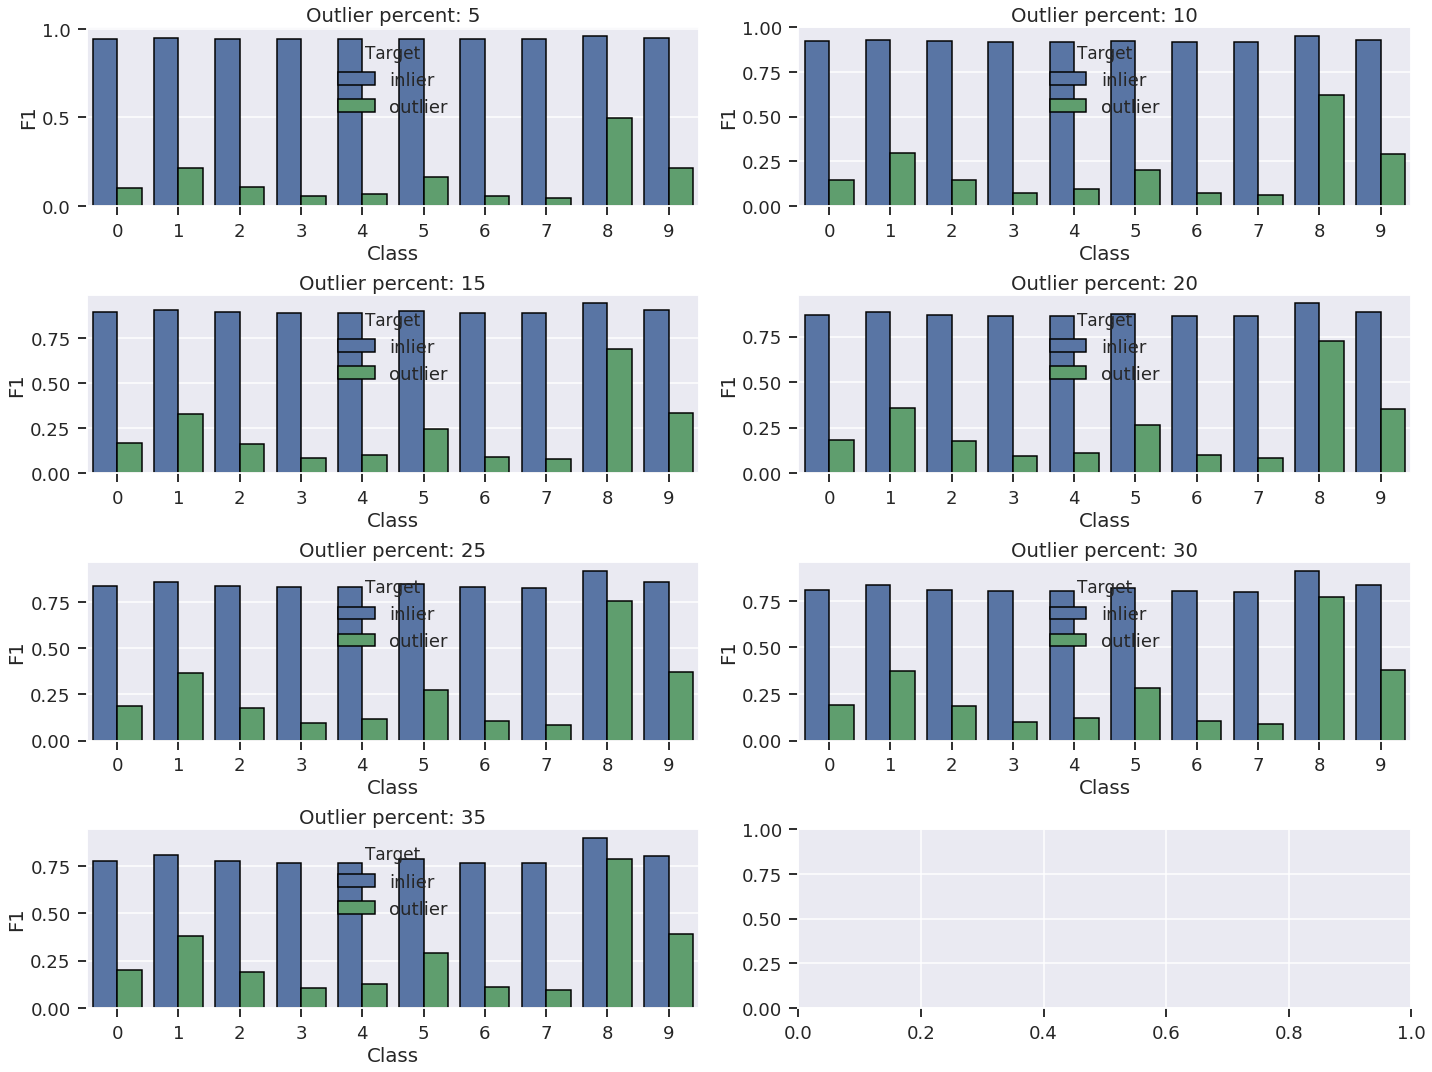




Threshold Percent :8


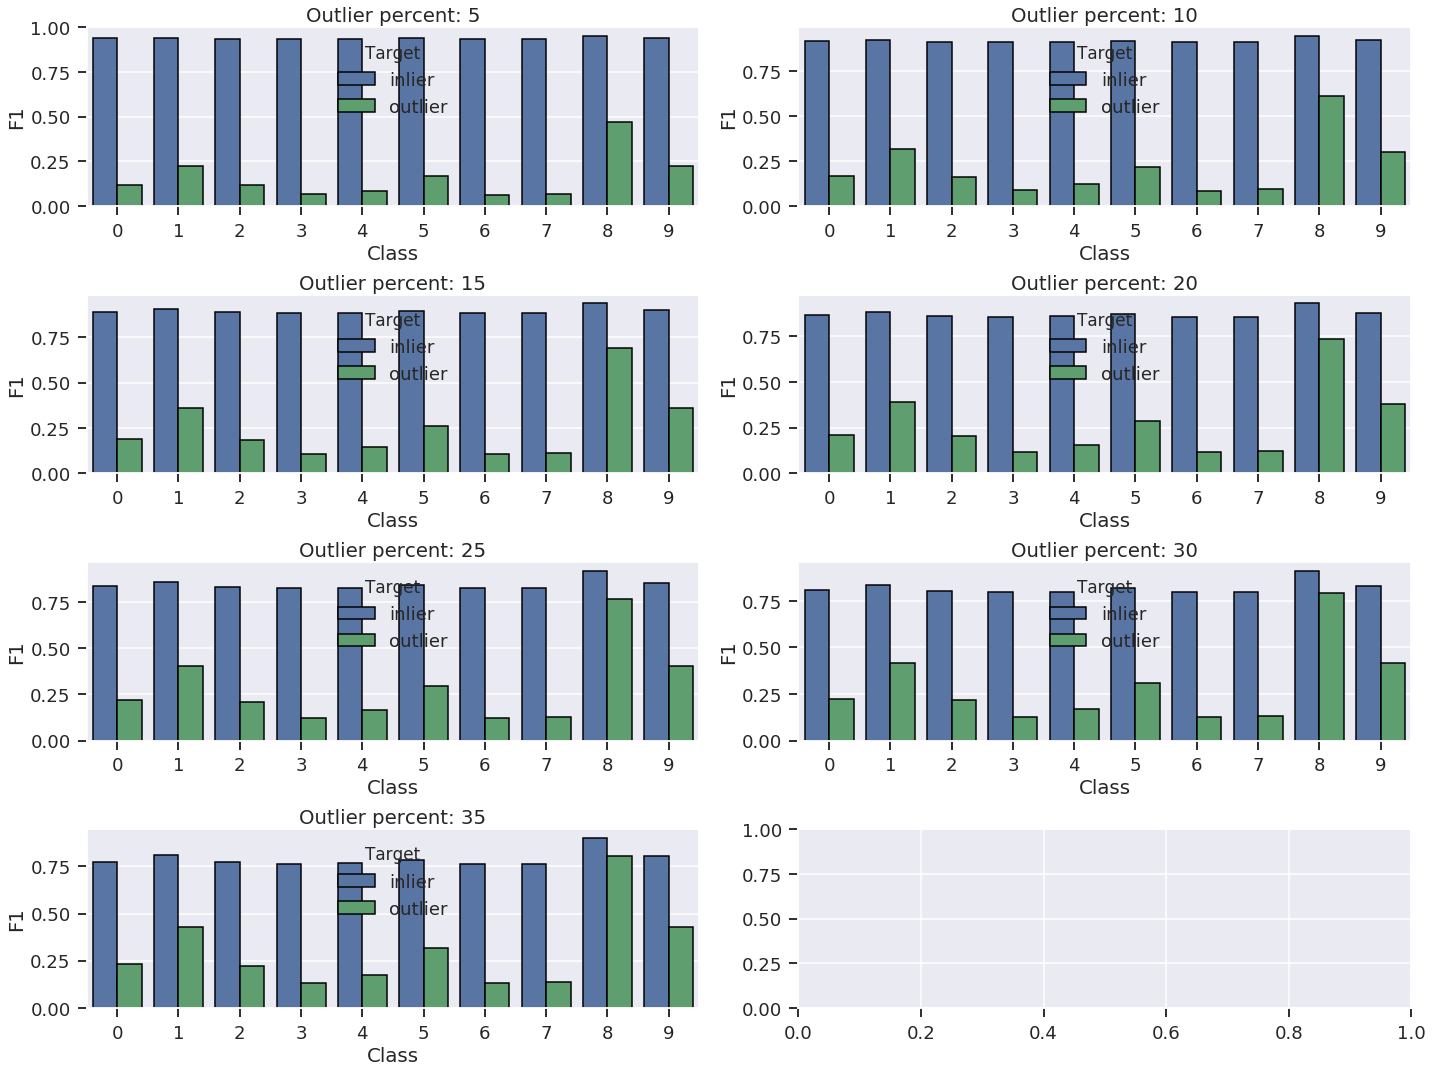




Threshold Percent :9.5


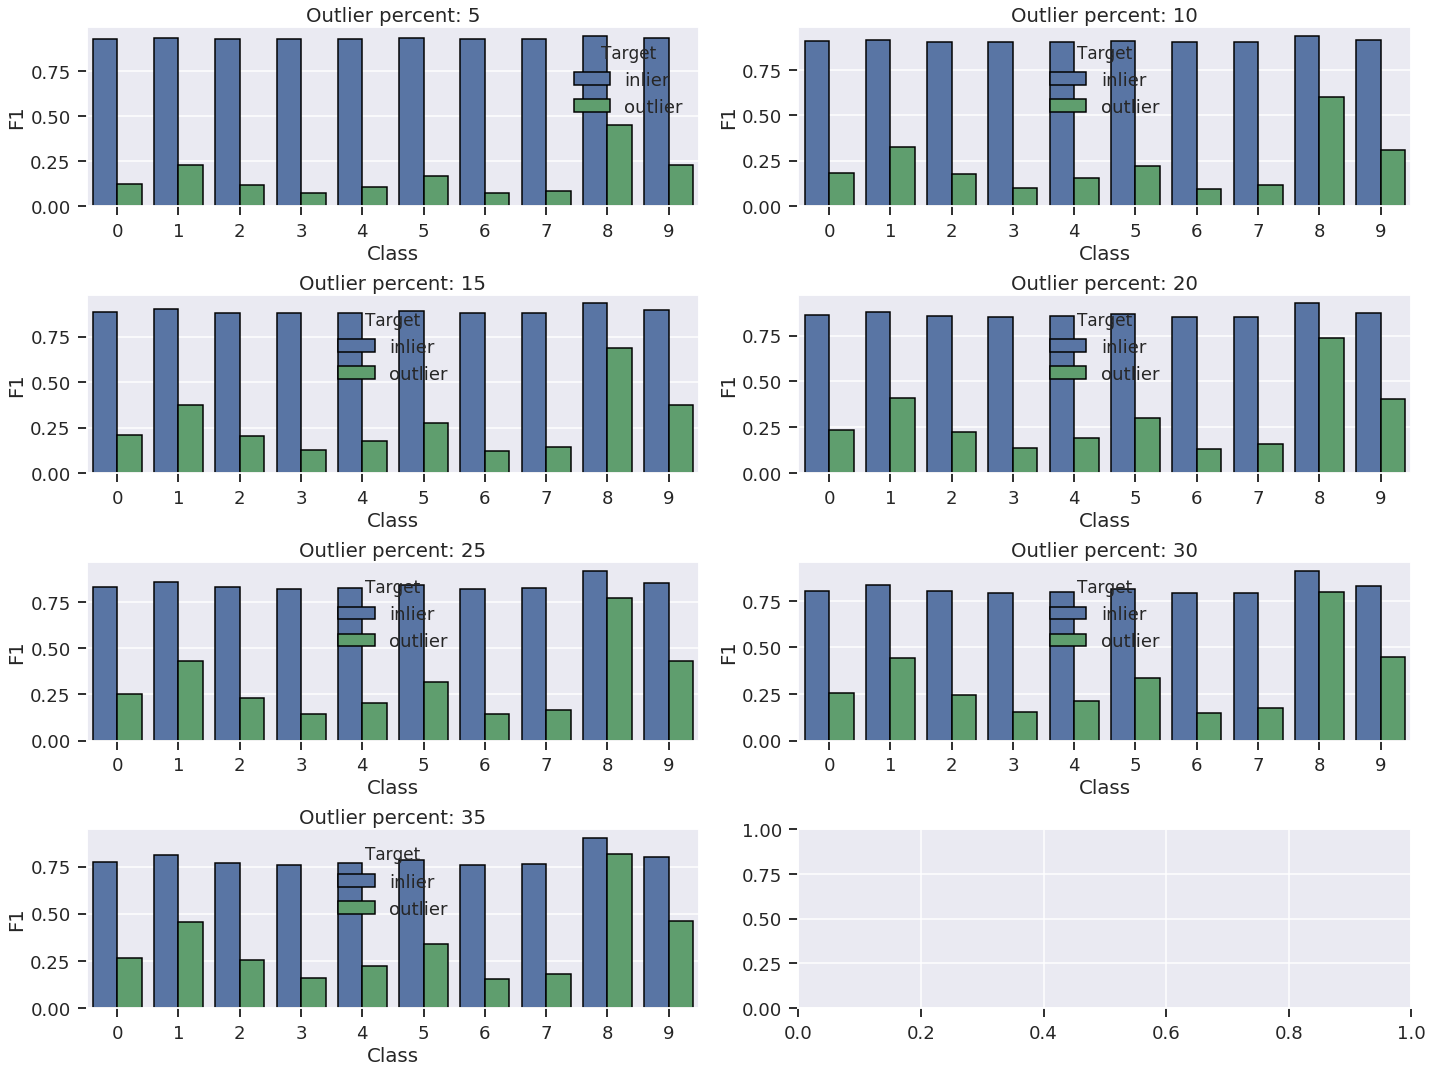




FMNIST-AUROC


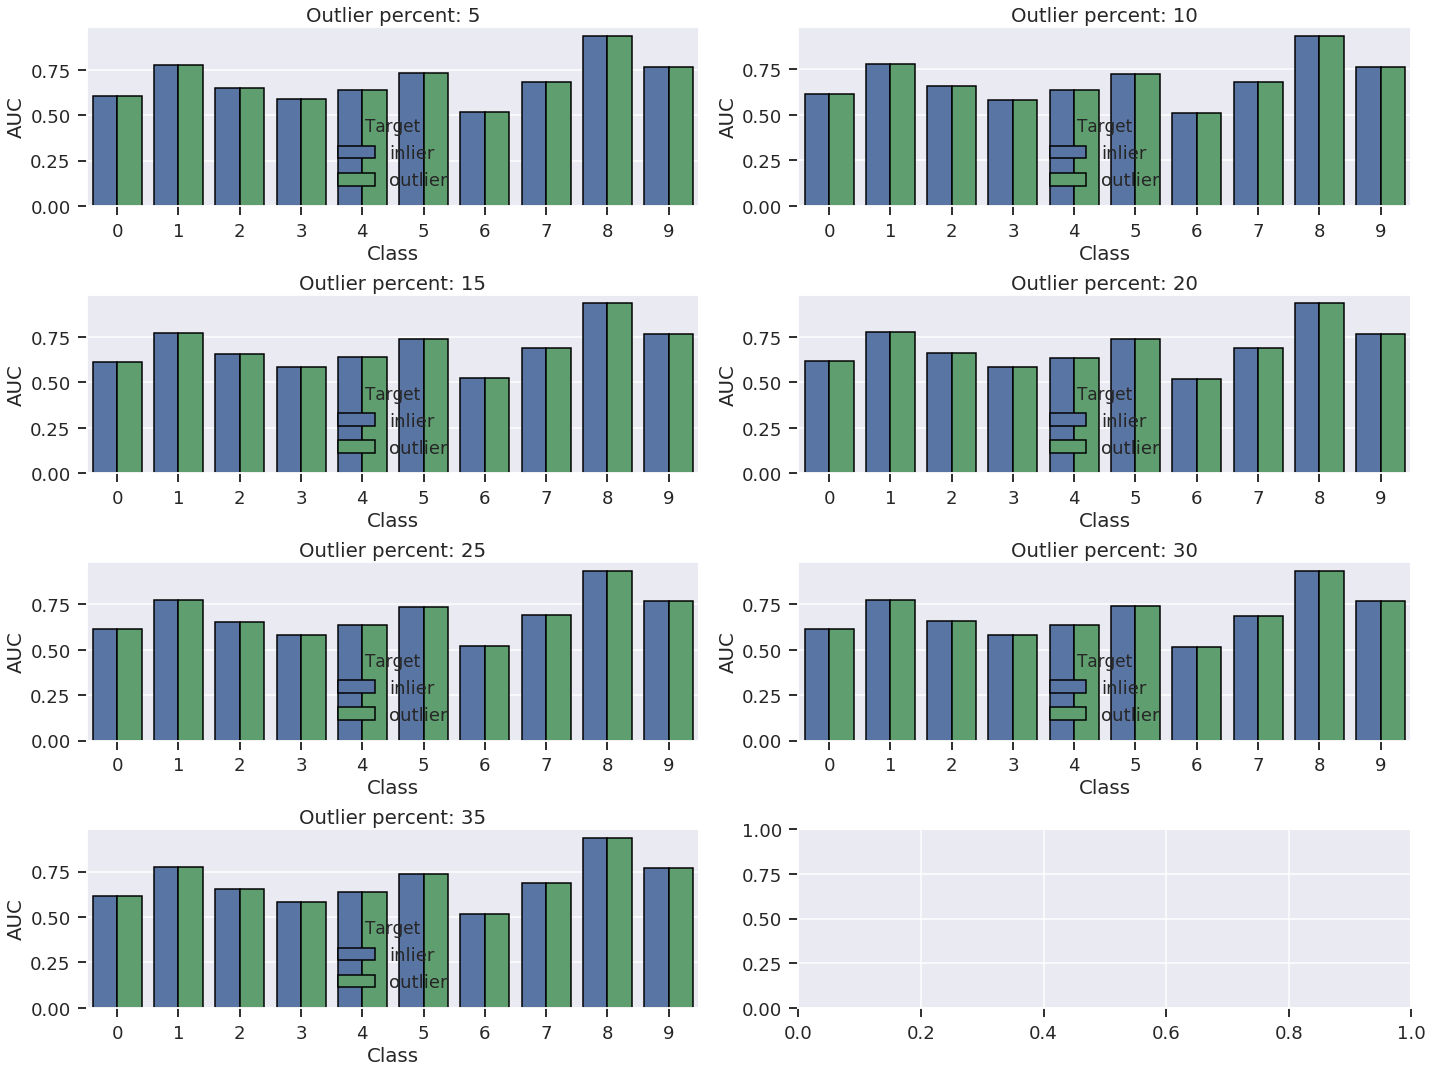




FMNIST-AUPRC(auprin)


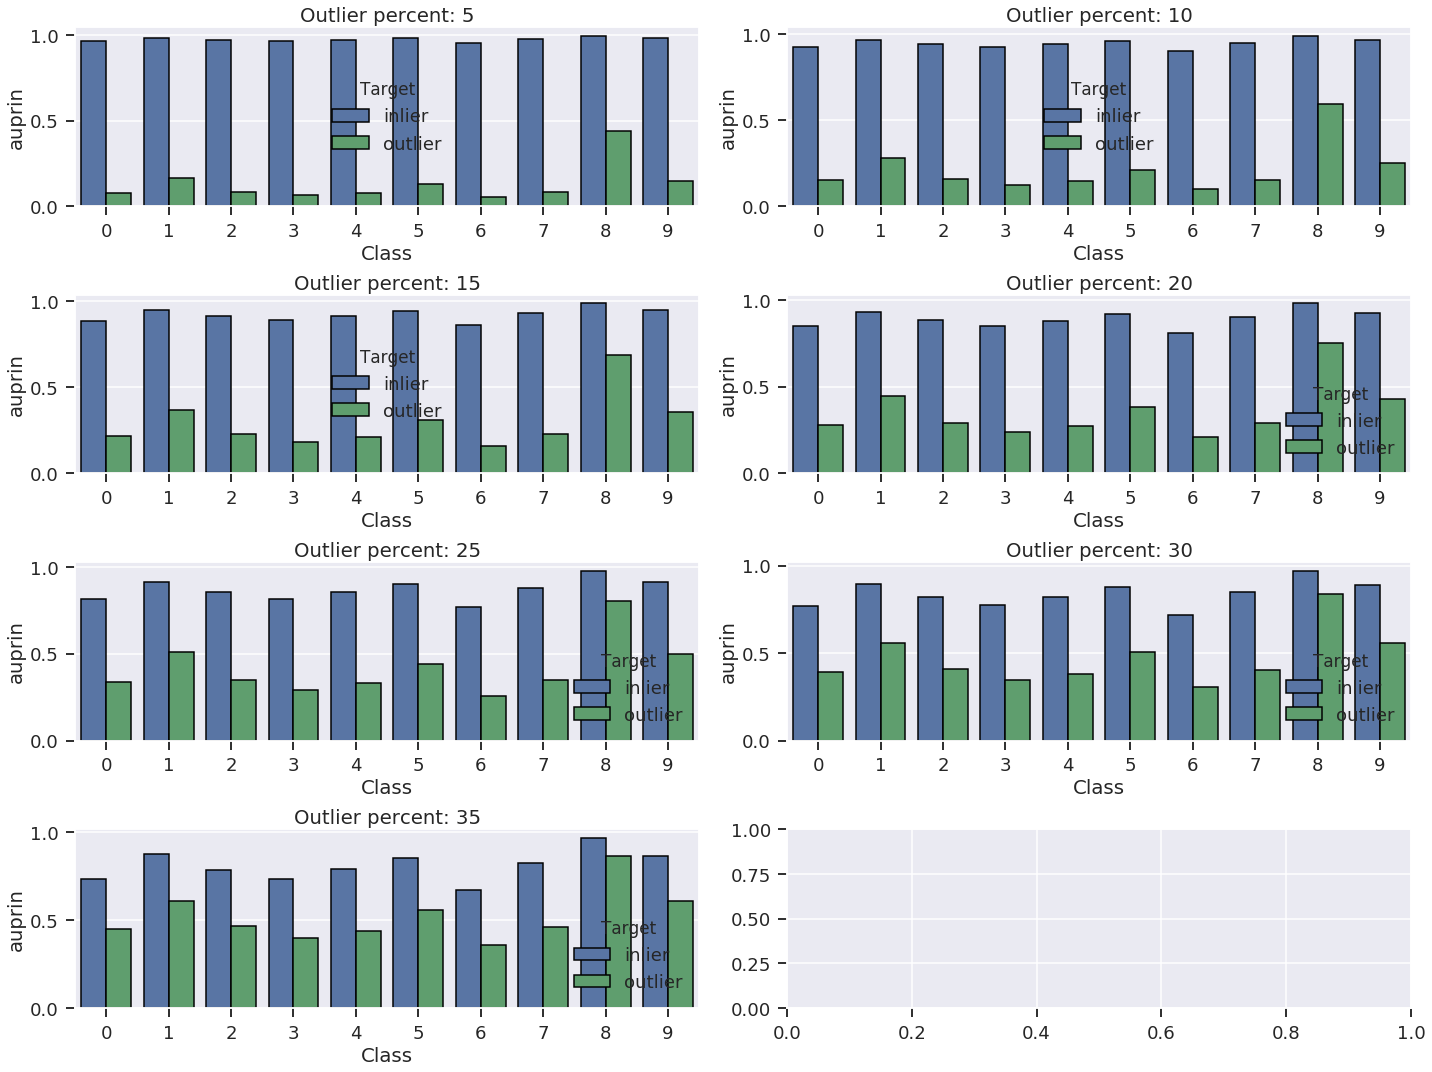

In [223]:
df = get_data_df("f_test_fold_{}")

# F1만 Threshold percent 관여 
_df = df.groupby(["Class", "Outlier Percent", "Threshold Percent", "Target"]).agg({
    "F1":np.mean,
    "AUC":np.mean,
    "auprin":np.mean,
    "auprout":np.mean,
}).reset_index()

# F1만 Threshold percent 관여 
thres_percents = ['0.5', '2', '3.5', '5', '6.5', '8', '9.5']

print("FMNIST-F1")
for thres in thres_percents:
    print("Threshold Percent :{}".format(thres))
    plot_result(_df[_df['Threshold Percent'] == thres], "F1")
    
print("FMNIST-AUROC")
plot_result(_df, "AUC")
print("FMNIST-AUPRC(auprin)")
plot_result(_df, "auprin")

In [227]:
_df[(_df['Target'] == "outlier")].groupby(['Outlier Percent', 'Class']).agg(
    {
        "auprin":['mean', 'std'],
#         "AUC":['mean', 'std'],
    }
).loc[35]

auprin       
        mean    std
Class              
0     0.4502 0.0000
1     0.6065 0.0000
2     0.4637 0.0000
3     0.3967 0.0000
4     0.4335 0.0000
5     0.5545 0.0000
6     0.3577 0.0000
7     0.4568 0.0000
8     0.8634 0.0000
9     0.6090 0.0000

In [19]:
# GPND_MRX_MNIST_df = get_data_df("test_fold_{}")
# GPND_MRX_MNIST_df['Outlier Percent'] = GPND_MRX_MNIST_df['Outlier Percent'] / 100
v
# # Test fold끼리는 mean
# GPND_MRX_MNIST_df = GPND_MRX_MNIST_df.groupby(["Class", "Outlier Percent", 'Target', 'Threshold Percent'])[['F1', 'AUC', 'auprin']].mean().reset_index()
# GPND_MRX_MNIST_df.rename(
#     columns={
#         "F1":"f1",
#         "auprin":"prc",
#         "AUC":"roc"
#     }, inplace=True
# )

# GPND_MRX_MNIST_outlier_target_df = GPND_MRX_MNIST_df[GPND_MRX_MNIST_df['Target'] == "outlier"]
# GPND_MRX_MNIST_outlier_target_df.rename(columns={
#     "f1": "GPND_MRX_outlier_f1",
#     "roc": "GPND_MRX_outlier_roc",
#     "prc": "GPND_MRX_outlier_prc",
# }, inplace=True)
# GPND_MRX_MNIST_outlier_target_df.drop('Target', axis=1, inplace=True)

# GPND_MRX_MNIST_outlier_target_df.drop_duplicates(["AUC", "Detection error", "auprin"])

# # 우선은 roc, prc만 볼것이기 때문에, f1_quantile로 분류된 결과는 날려버리기
# GPND_MRX_MNIST_outlier_target_df = GPND_MRX_MNIST_outlier_target_df.drop_duplicates(
#     subset=['Class', 'Outlier Percent', 'GPND_MRX_outlier_roc', 'GPND_MRX_outlier_prc'], keep='first'
# )
# GPND_MRX_MNIST_outlier_target_df.head()

In [29]:
def highlight_max(x, measure): 
    c1 = 'background-color: yellow'
    c2 = '' 

    m = x.groupby(level=0)[measure + "_mean"].transform('max').eq(x[measure + "_mean"])
    df1 = pd.DataFrame(c2, index=x.index, columns=x.columns)
    df1.loc[m, measure + "_mean"] = c1
#     _df1 = df1[[measure + "_mean"]].copy()

#     m = x.groupby(level=0)[measure + "_std"].transform('min').eq(x[measure + "_std"])
#     df1 = pd.DataFrame(c2, index=x.index, columns=x.columns)
#     df1.loc[m, measure + "_std"] = c1
#     _df2 = df1[[measure + "_std"]].copy()

    return df1

In [30]:
# subplots by novelty (10 subplots)

def compare_plot(measure_df, ncols, subplot_group_name, x_index, measure):
    subplot_group_list = sorted(measure_df[subplot_group_name].unique())
    subplot_class_index = 0

    nrows = math.ceil(len(subplot_group_list)/ncols)

    num_method = measure_df['method'].nunique()
    hue_order = sorted(measure_df['method'].unique())

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 5*len(subplot_group_list)))
    for row in range(nrows):
        for col in range(ncols):
            if (row+1) * (col+1) > len(subplot_group_list):
                continue
            if axes.ndim > 1:
                ax = axes[row][col]
            else:
                ax = axes[row]
            subplot_group = subplot_group_list[subplot_class_index]

            tmp_df = measure_df[measure_df[subplot_group_name] == subplot_group]

            _ = sns.barplot(
                data=tmp_df, x=x_index, y=measure, hue="method", ax=ax, hue_order=hue_order,
                palette=sns.diverging_palette(240, 10, n=num_method),
#                 palette=sns.cubehelix_palette(n_colors=num_method), 
            )
            _ = ax.set_title("{}: {}".format(subplot_group_name, subplot_group));
            _ = ax.set_ylim([0.5, 1])
            _ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

            subplot_class_index += 1
    _ = plt.subplots_adjust(hspace=2)
    _ = plt.xticks(rotation=0)
    _ = plt.tight_layout()
    
    # 뭉개기
    
    crushed_df = measure_df.groupby([x_index, 'method']).agg({measure:[np.mean, np.std]})
    crushed_df.columns = crushed_df.columns.get_level_values(0) + "_" + crushed_df.columns.get_level_values(1)
    _crushed_df = crushed_df.reset_index()
       
    _ = plt.figure()
    ax = sns.barplot(data=_crushed_df, x=x_index, y=measure + "_mean", hue='method', hue_order=hue_order)
    _ = ax.set_title(measure+ "_mean")
    _ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    _ = plt.figure()
    ax = sns.barplot(data=_crushed_df, x=x_index, y=measure + "_std", hue='method', hue_order=hue_order)
    _ = ax.set_title(measure+ "_std")
    _ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return crushed_df

In [31]:
def get_both_data(fashion):
    #
    # GPND
    #
    if fashion:
        GPND_MNIST_df = get_data_df("original_f_test_fold_{}")
    else:
        GPND_MNIST_df = get_data_df("original_test_fold_{}")
    GPND_MNIST_df['Outlier Percent'] = GPND_MNIST_df['Outlier Percent'] / 100

    # Test fold끼리는 mean
    GPND_MNIST_df = GPND_MNIST_df.groupby(["Class", "Outlier Percent", 'Target'])[['F1', 'AUC', 'auprin']].mean().reset_index()
    GPND_MNIST_outlier_target_df = GPND_MNIST_df[GPND_MNIST_df['Target'] == "outlier"]
    GPND_MNIST_outlier_target_df.rename(columns={
        "F1": "GPND_outlier_f1",
        "AUC": "GPND_outlier_roc",
        "auprin": "GPND_outlier_prc",
    }, inplace=True)
    GPND_MNIST_outlier_target_df.drop('Target', axis=1, inplace=True)

    
    #
    # MRX
    #
#     if fashion:
#         input_fn = 'result_MRX/20190305.uae.fmnist.one_class.csv'
#     else:
#         input_fn = 'result_MRX/20190305.uae.mnist.one_class.csv'
        

#     _df = pd.read_csv(input_fn, index_col=0)
#     _df.drop(_df.filter(like="d_trunc").columns, axis=1, inplace=True)
#     _df.rename(columns={"novelty_ratio":"Outlier Percent", "novelty":"Class"}, inplace=True)

#     roc_cols = list(_df.filter(like="roc").columns)
#     prc_cols = list(_df.filter(like="prc").columns)

#     mrx_mean_by_trial_df = _df.groupby(['Class', 'Outlier Percent', 'f1_quantile'])[prc_cols + roc_cols].mean().reset_index()

#     # 우선은 roc, prc만 볼것이기 때문에, f1_quantile로 분류된 결과는 날려버리기
#     mrx_drop_f1_quantile_df = mrx_mean_by_trial_df.drop_duplicates(subset=roc_cols+prc_cols, keep='first')
     
    
    
    #
    # SVDD
    #
    total_data_list = []
    for fold in range(5):
        if fashion:
            f = open("result_SVDD/fmnist_test_{}/log.txt".format(fold))
        else:
            f = open("result_SVDD/mnist_test_{}/log.txt".format(fold))
        data_list = []

        for line in f:
            _line = line.strip()
            _line = _line.split("-")[-1].strip() 
            if _line:
                data_list.append(_line.split(":")[-1])
            else:
                if data_list:
                    total_data_list.append(data_list)
                    data_list = []

    df = pd.DataFrame(
        total_data_list,
        columns=["Class", "test_fold_id", "Outlier Percent", "AUC", "auprout"],
    )

    df['Class'] = df['Class'].astype("int")
    df['Outlier Percent'] = df['Outlier Percent'].astype("int") / 100
    df['test_fold_id'] = df['test_fold_id'].astype("int")

    df["AUC"] = df["AUC"].str[:-1].astype("float") / 100
    df["auprout"] = df["auprout"].str[:-1].astype("float") / 100

    SVDD_df = df.groupby(["Class", "Outlier Percent"])[['AUC', 'auprout']].mean().reset_index().rename(columns={
        "AUC":"SVDD_roc",
        "auprout":"SVDD_prc",
    })   
    
#     merged_df = pd.merge(mrx_drop_f1_quantile_df, GPND_MNIST_outlier_target_df, on=['Outlier Percent', 'Class'])
    merged_df = pd.merge(GPND_MNIST_outlier_target_df, SVDD_df, on=['Outlier Percent', 'Class'])
    return merged_df

In [37]:
merged_df = get_both_data(fashion=False)
merged_df.shape

(50, 7)

In [39]:
merged_df[['GPND_outlier_roc', 'SVDD_roc']].mean()

GPND_outlier_roc   0.9713
SVDD_roc           0.9371
dtype: float64

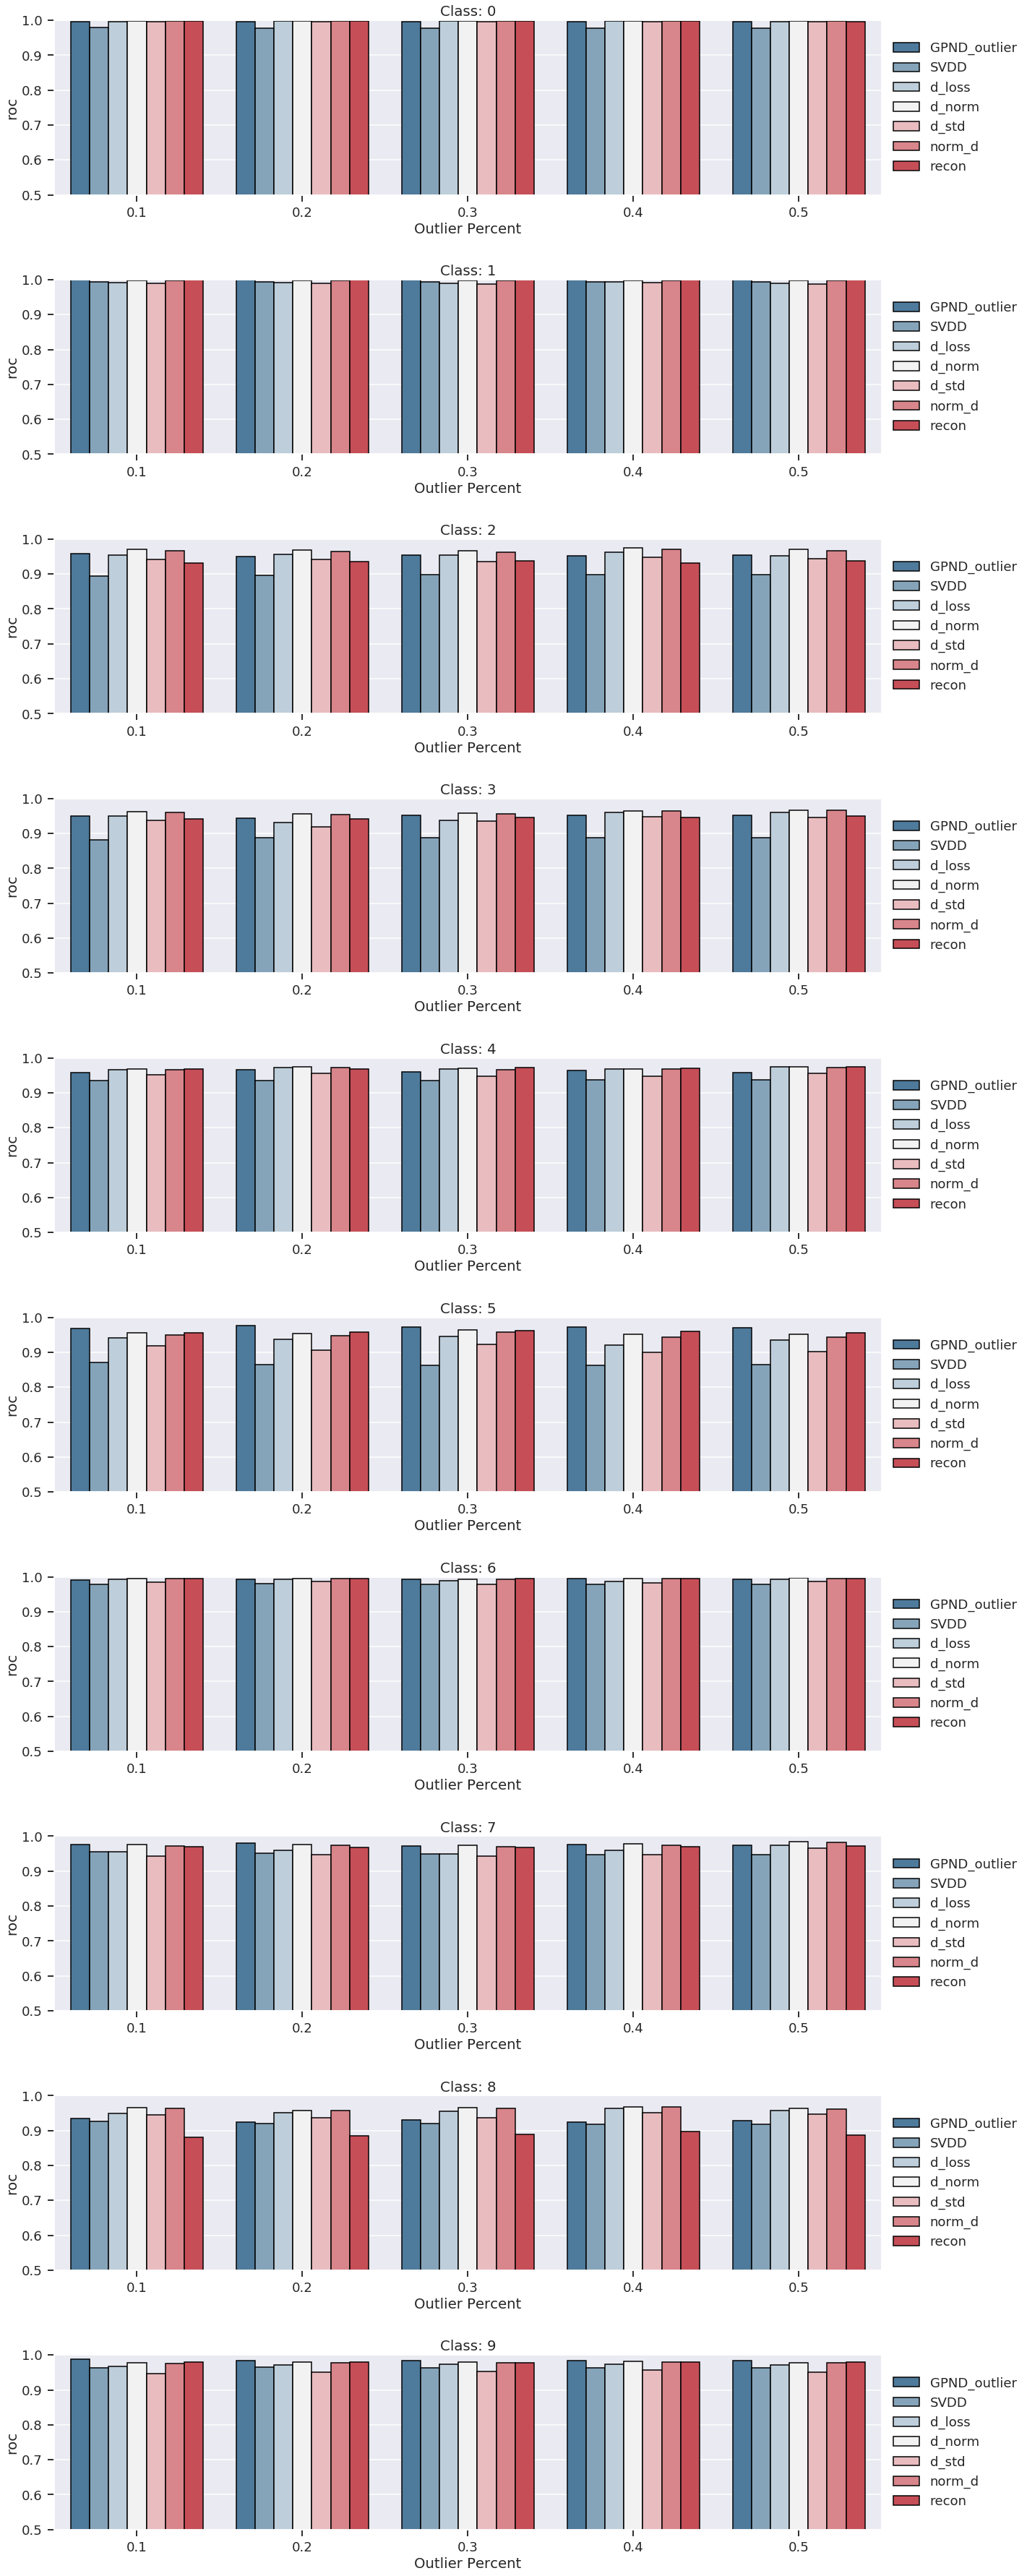

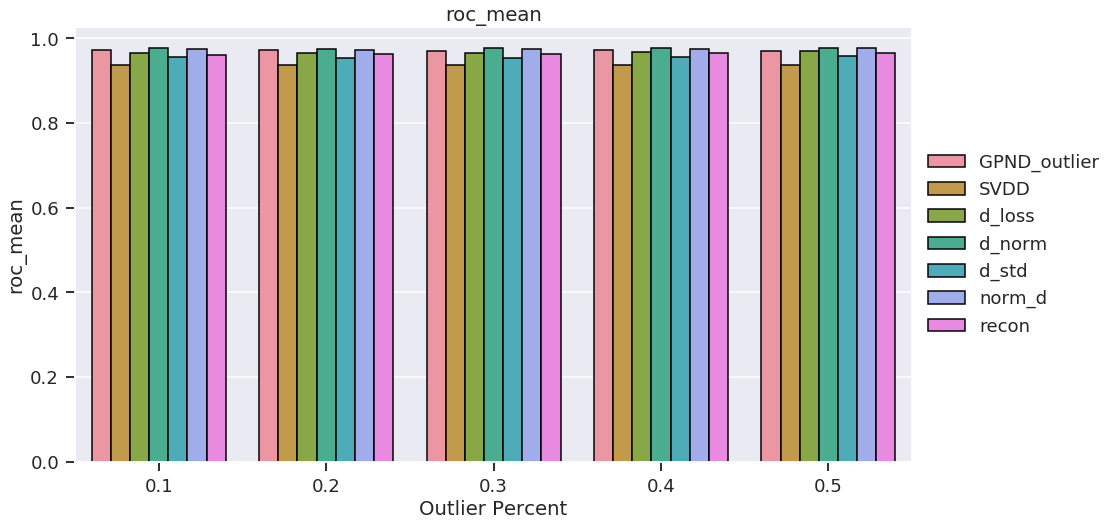

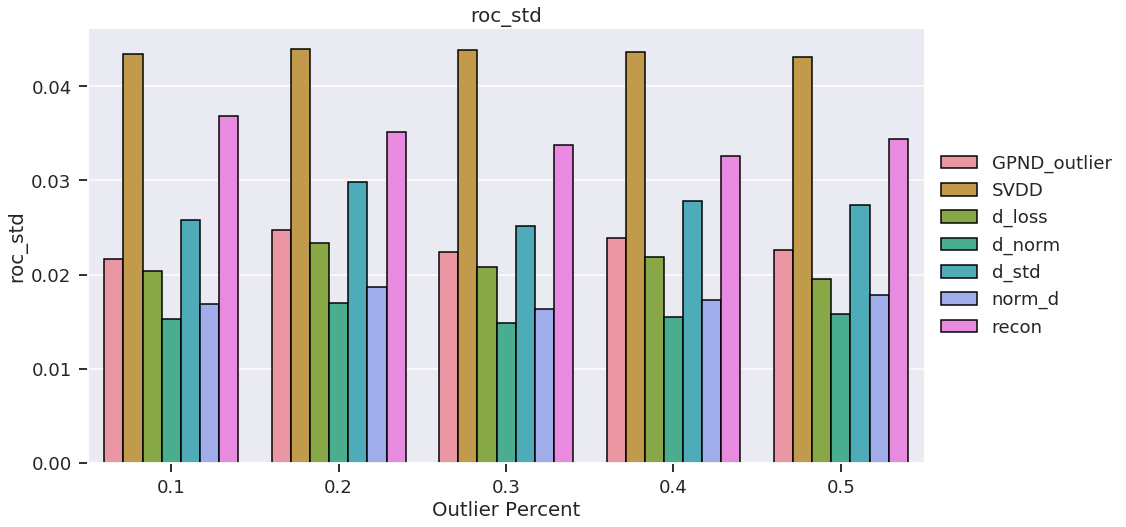

In [173]:
measure = "roc"

measure_df = pd.concat([merged_df[['Class', 'Outlier Percent']], merged_df.filter(like=measure)], axis=1)
measure_df = measure_df.melt(['Class', 'Outlier Percent']).rename(columns={"variable":"method", "value":measure})
measure_df['method'] = measure_df['method'].str[:-4]

crush_df = compare_plot(
    measure_df=measure_df,
    ncols=1,
    subplot_group_name="Class",
    x_index="Outlier Percent",
    measure=measure,
)

crush_df.round(4).style.apply(lambda x:highlight_max(x, measure), axis=None)

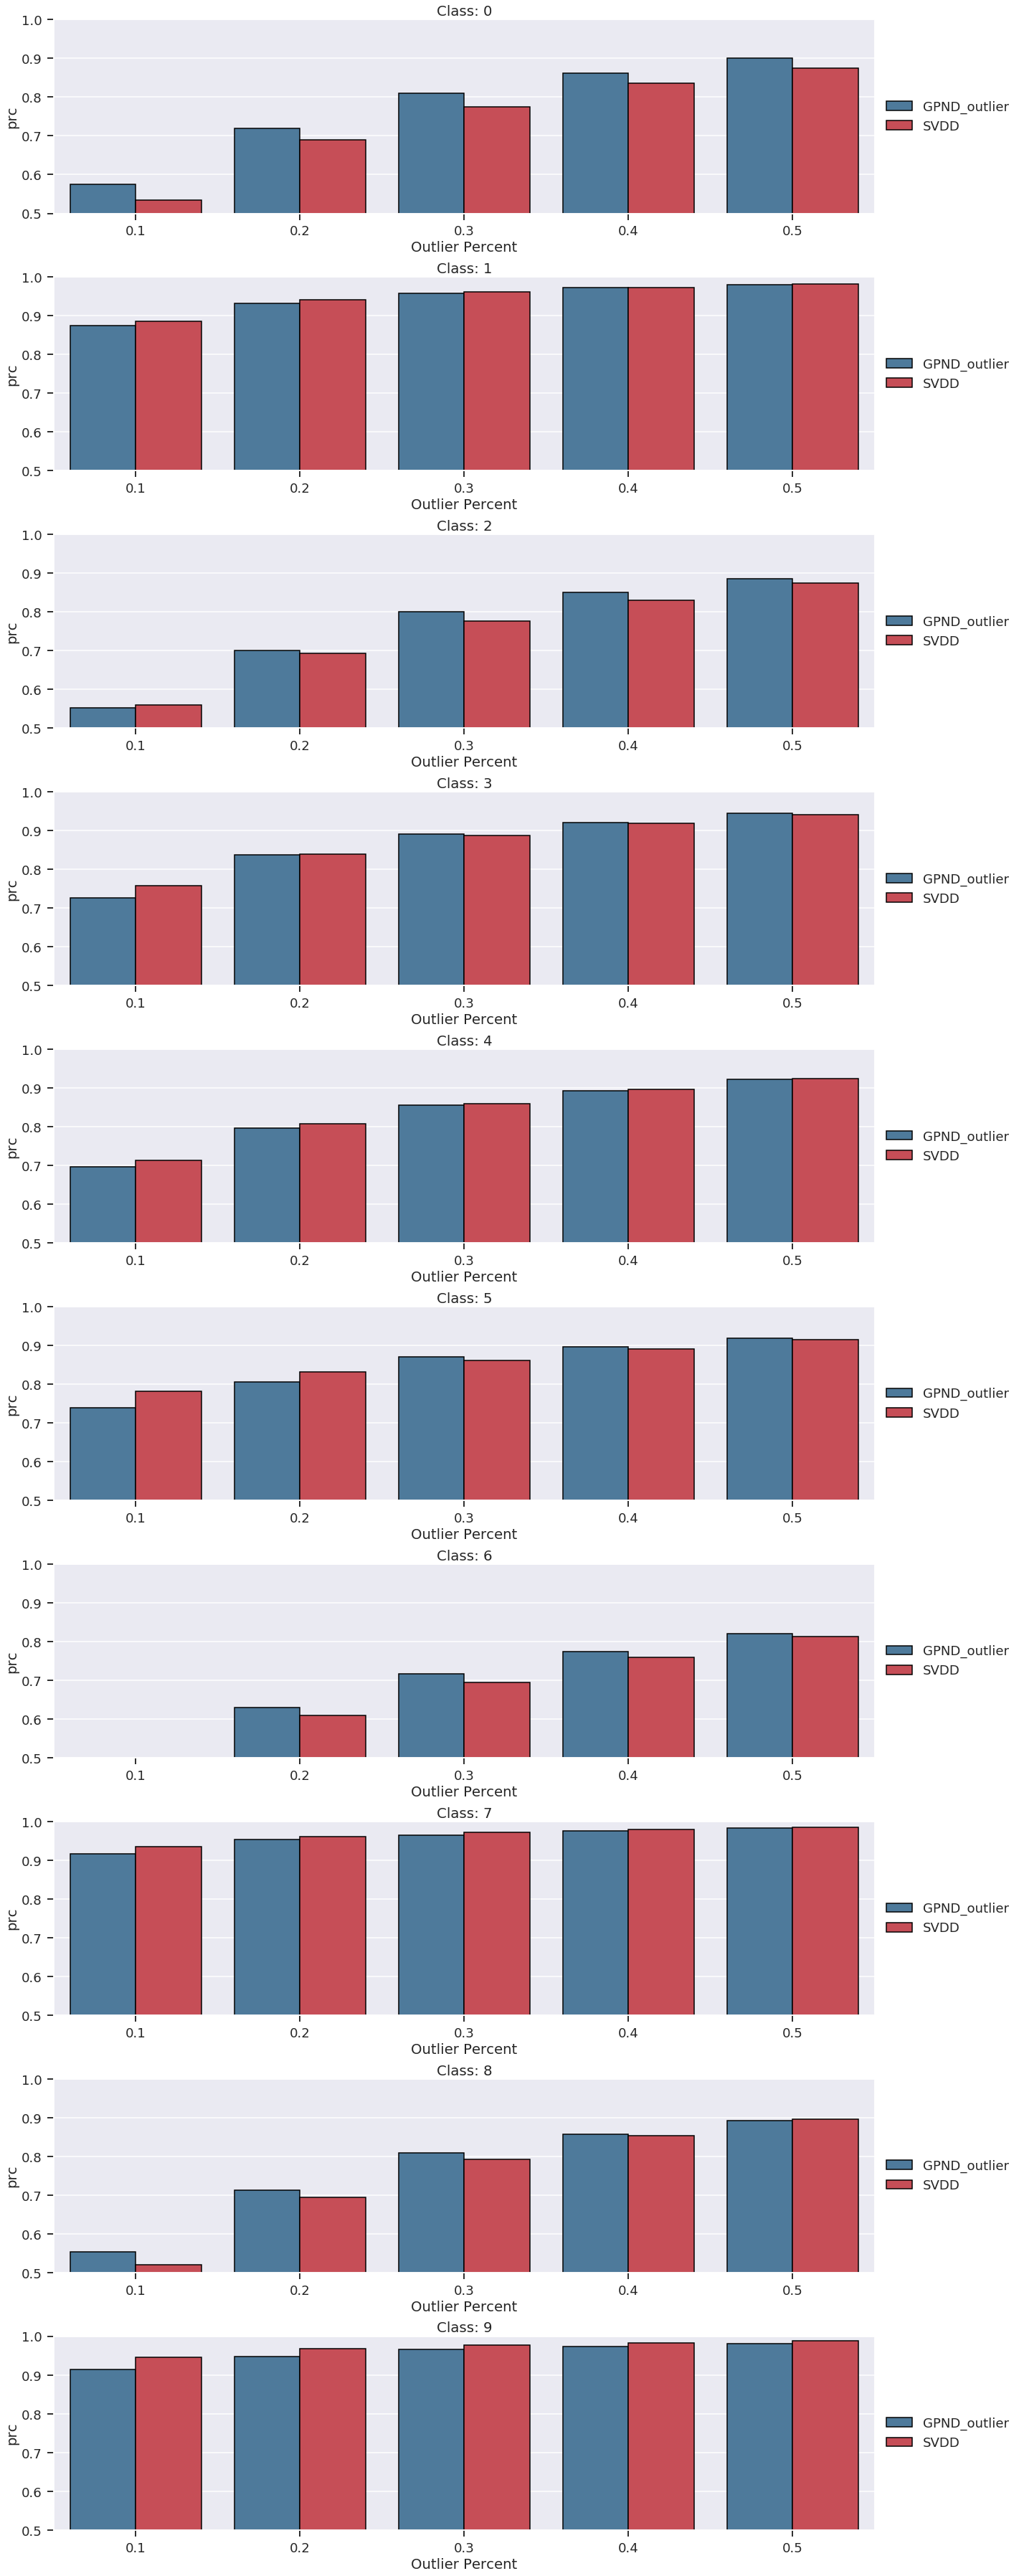

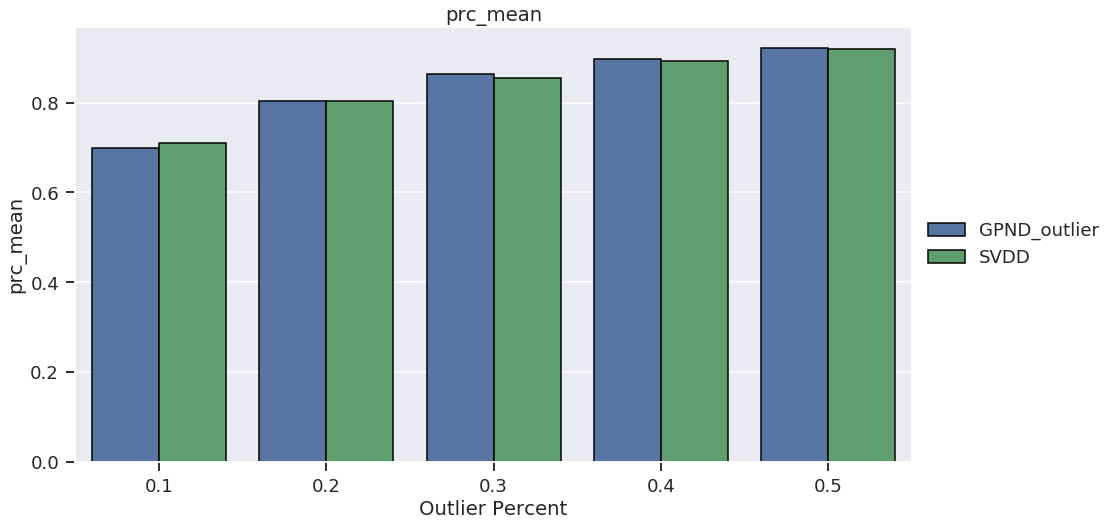

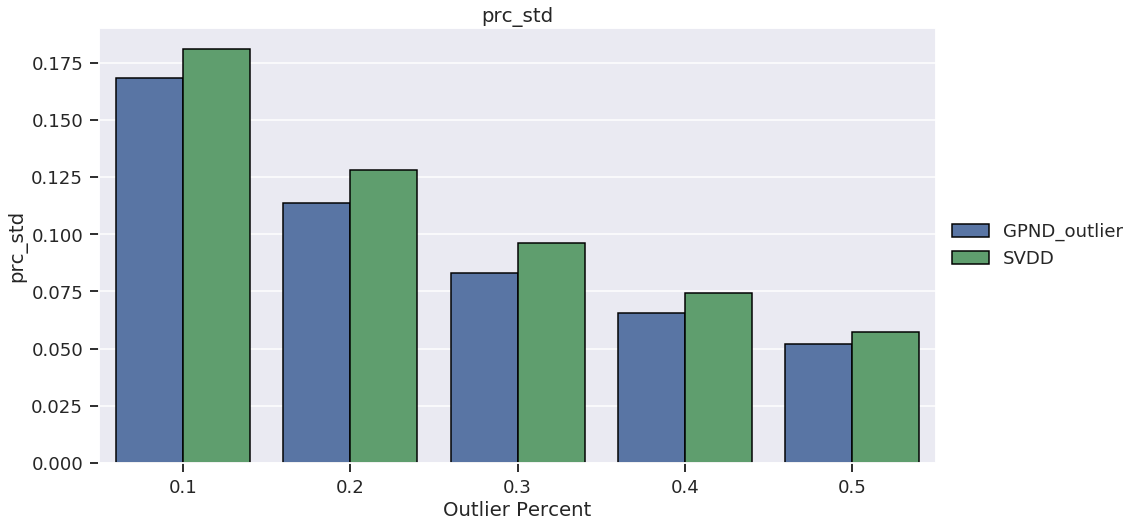

In [212]:
measure = "prc"

measure_df = pd.concat([merged_df[['Class', 'Outlier Percent']], merged_df.filter(like=measure)], axis=1)
measure_df = measure_df.melt(['Class', 'Outlier Percent']).rename(columns={"variable":"method", "value":measure})
measure_df['method'] = measure_df['method'].str[:-4]

crush_df = compare_plot(
    measure_df=measure_df,
    ncols=1,
    subplot_group_name="Class",
    x_index="Outlier Percent",
    measure=measure,
)

crush_df.round(4).style.apply(lambda x:highlight_max(x, measure), axis=None)

In [213]:
crush_df.loc[crush_df.index.get_level_values(1) == 'SVDD']

,,prc_mean,prc_std
Outlier Percent,method,,
0.1000,SVDD,0.7093,0.1812
0.2000,SVDD,0.8035,0.1281
0.3000,SVDD,0.8557,0.0963
0.4000,SVDD,0.8919,0.0743
0.5000,SVDD,0.9195,0.0571


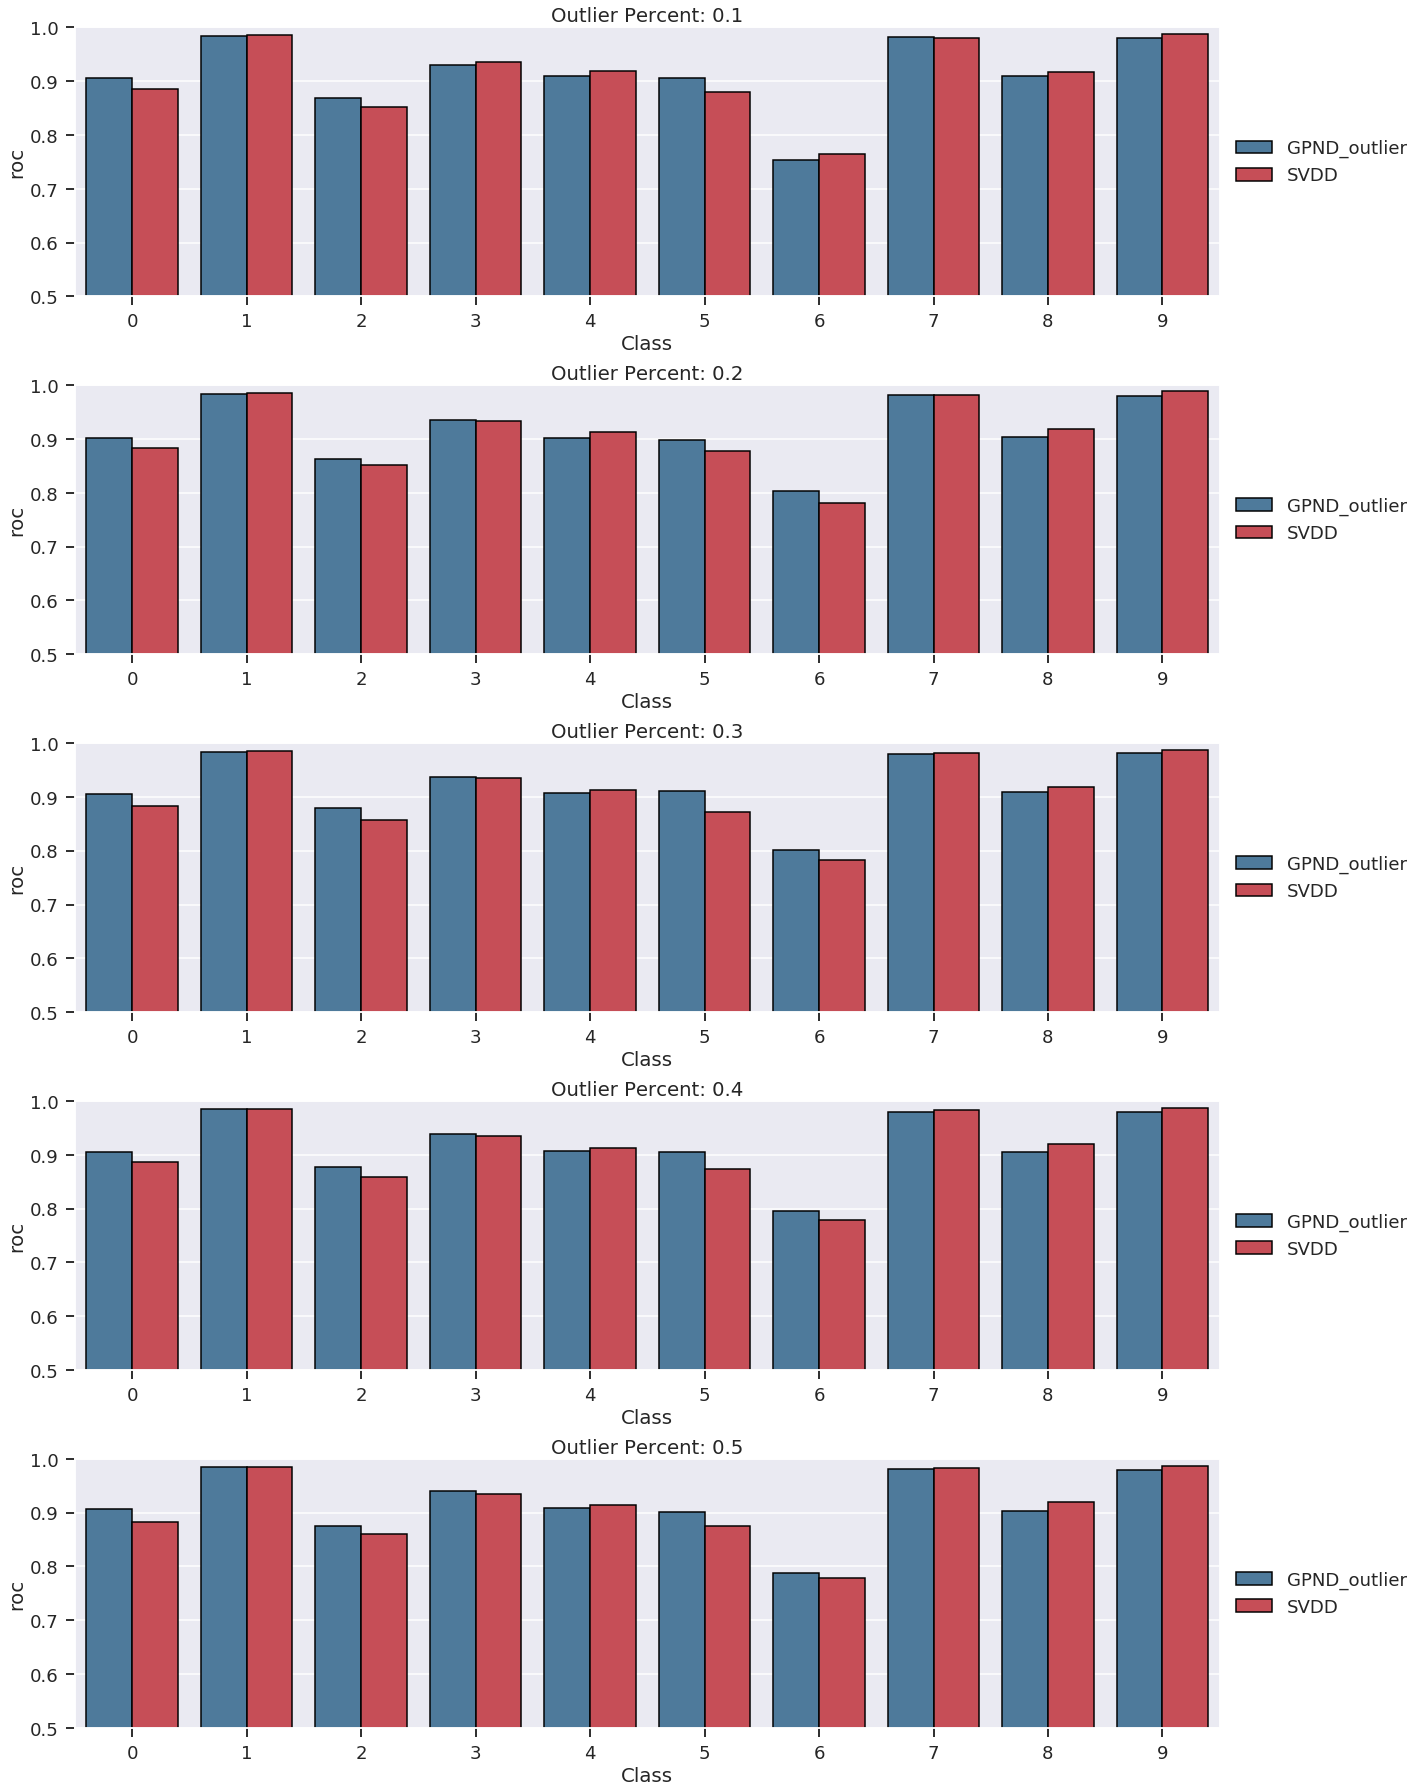

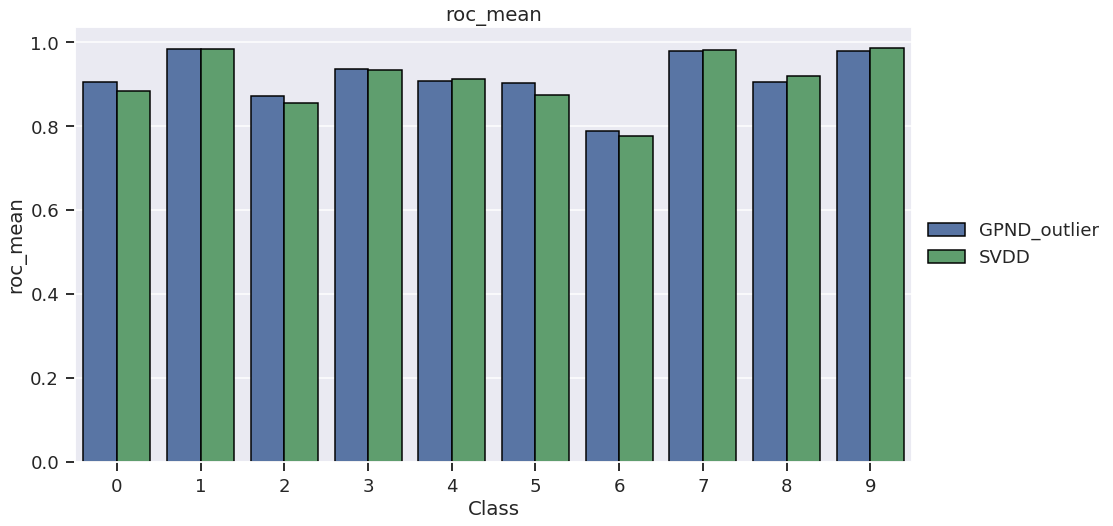

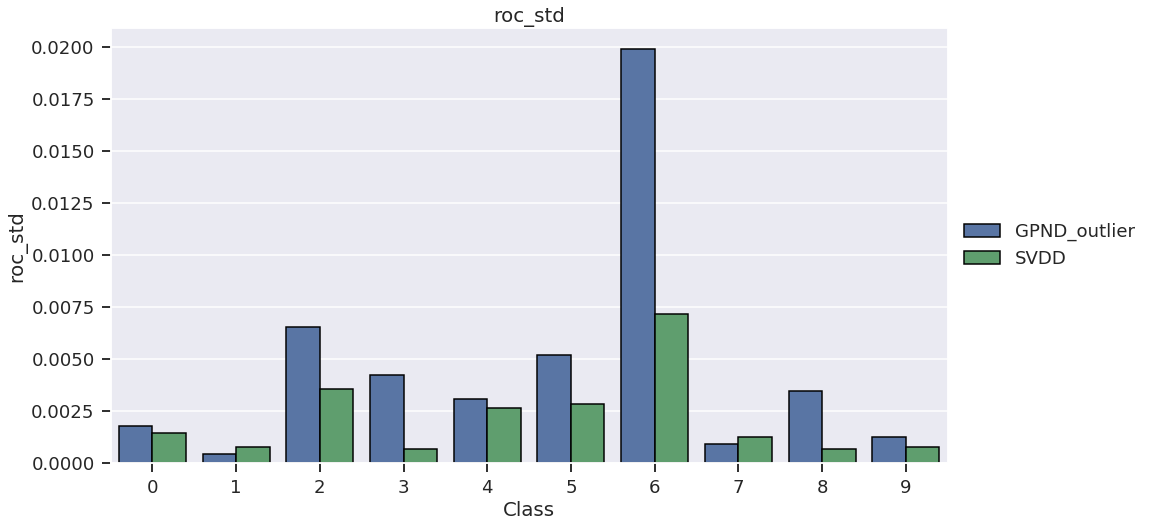

In [214]:
measure = "roc"

measure_df = pd.concat([merged_df[['Class', 'Outlier Percent']], merged_df.filter(like=measure)], axis=1)
measure_df = measure_df.melt(['Class', 'Outlier Percent']).rename(columns={"variable":"method", "value":measure})
measure_df['method'] = measure_df['method'].str[:-4]

crush_df = compare_plot(
    measure_df=measure_df,
    ncols=1,
    subplot_group_name="Outlier Percent",
    x_index="Class",
    measure=measure,
)

crush_df.round(4).style.apply(lambda x:highlight_max(x, measure), axis=None)

In [215]:
crush_df.loc[crush_df.index.get_level_values(1) == 'SVDD']

,,roc_mean,roc_std
Class,method,,
0,SVDD,0.8840,0.0014
1,SVDD,0.9852,0.0008
2,SVDD,0.8558,0.0035
3,SVDD,0.9347,0.0006
4,SVDD,0.9140,0.0026
5,SVDD,0.8754,0.0028
6,SVDD,0.7771,0.0071
7,SVDD,0.9821,0.0013
8,SVDD,0.9188,0.0007


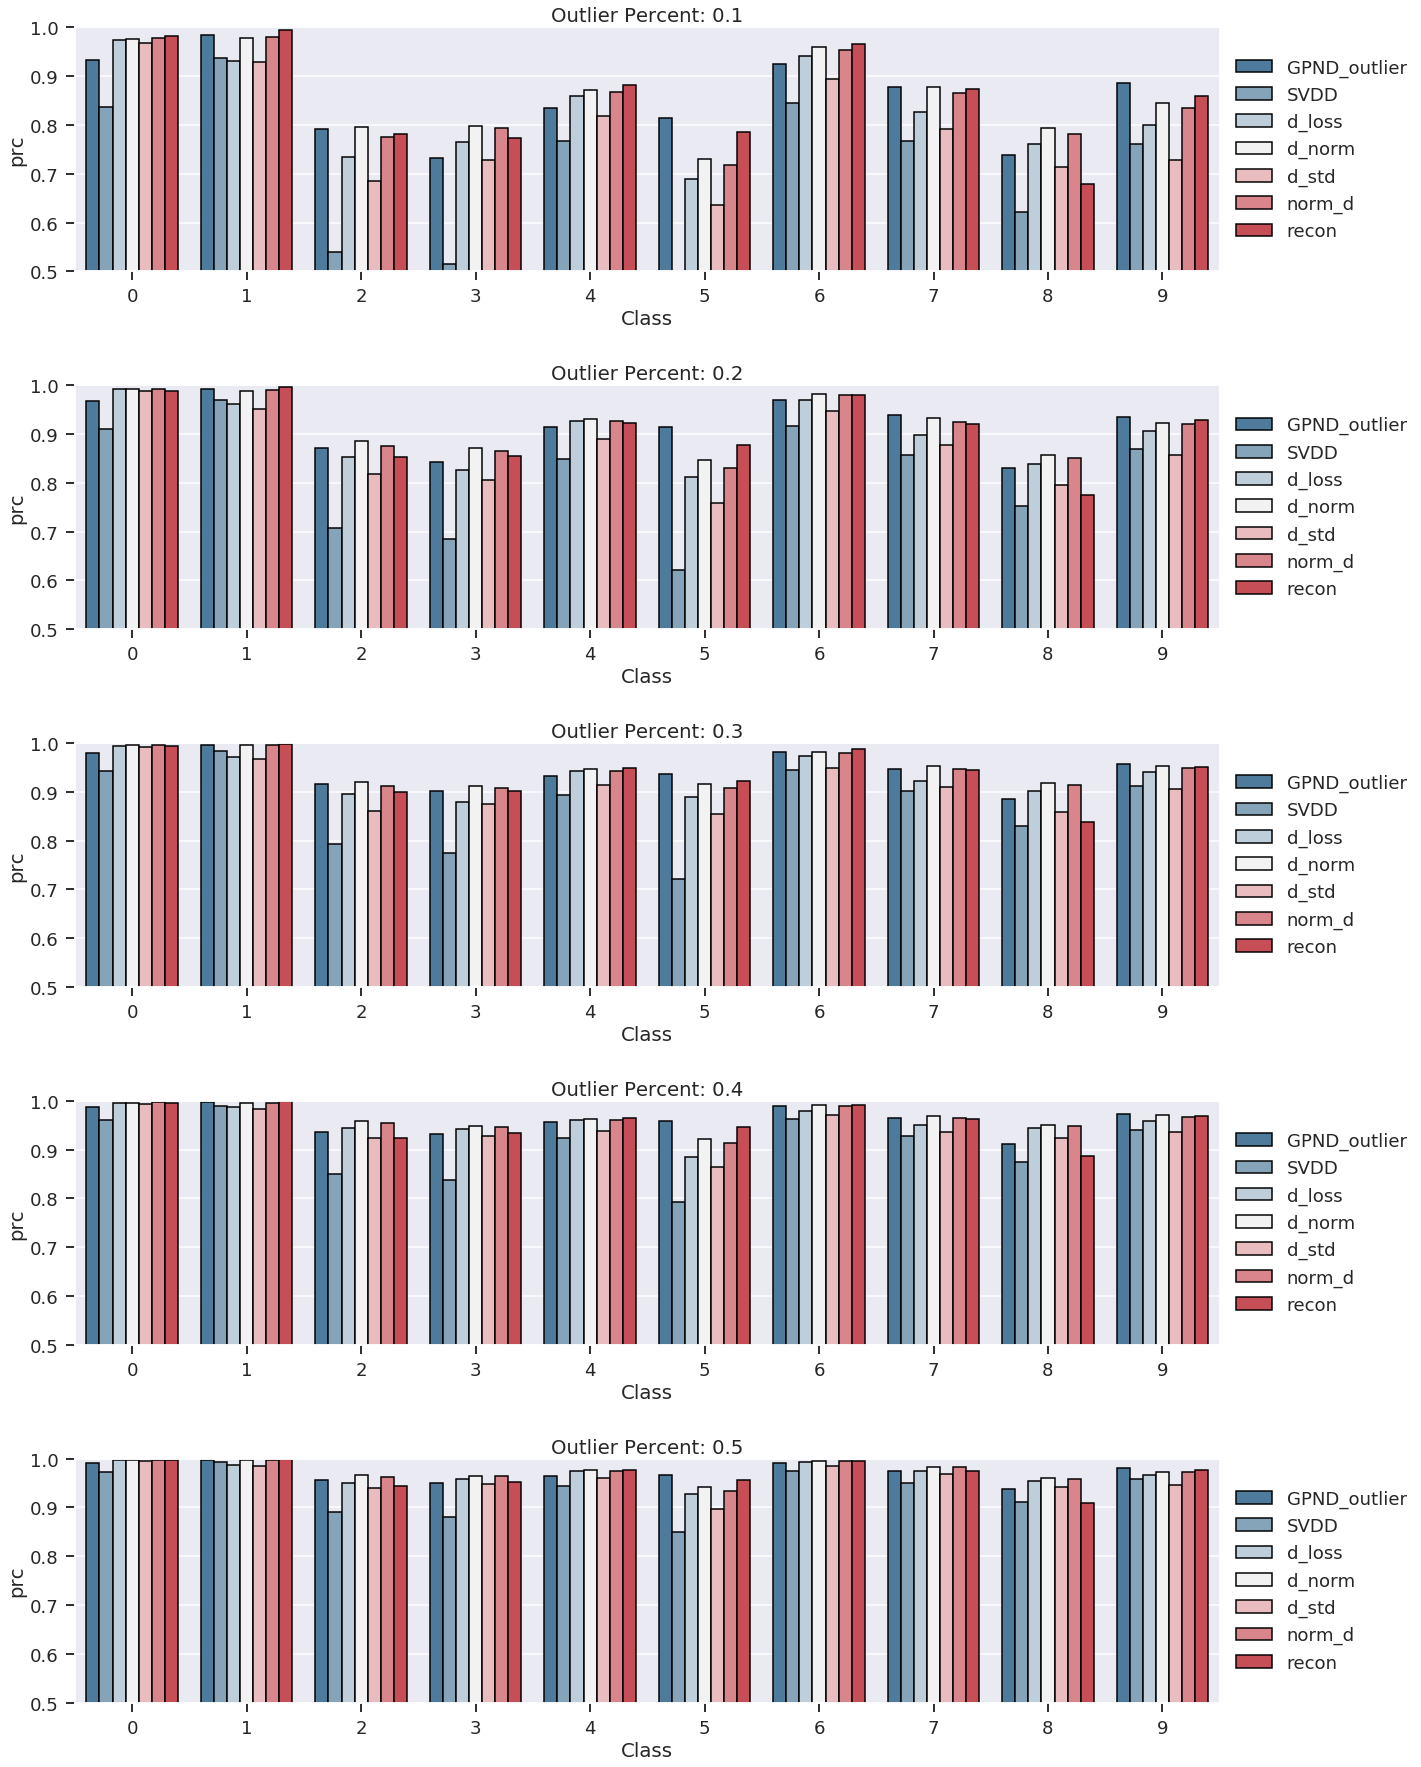

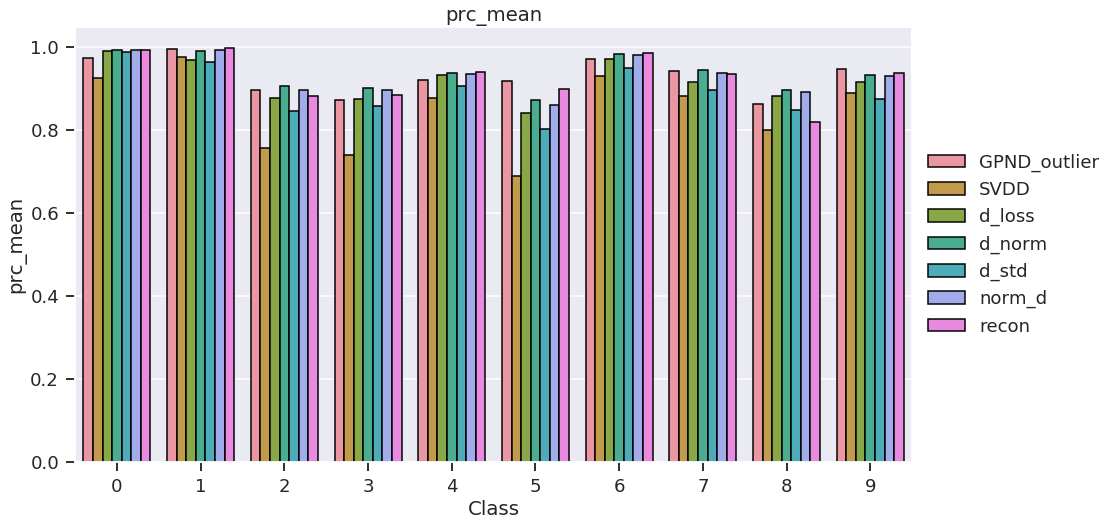

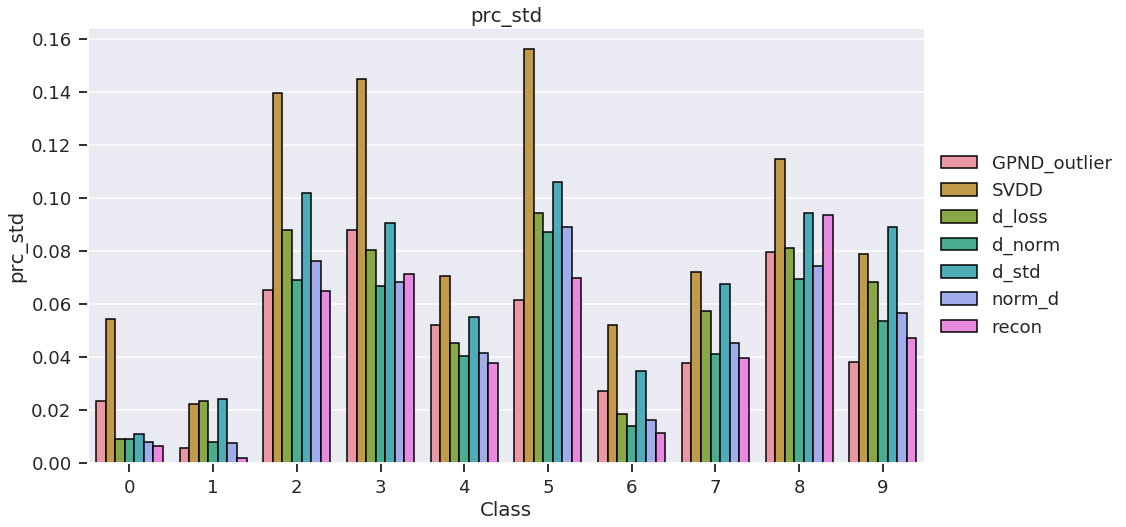

In [118]:
measure = "prc"

measure_df = pd.concat([merged_df[['Class', 'Outlier Percent']], merged_df.filter(like=measure)], axis=1)
measure_df = measure_df.melt(['Class', 'Outlier Percent']).rename(columns={"variable":"method", "value":measure})
measure_df['method'] = measure_df['method'].str[:-4]

crush_df = compare_plot(
    measure_df=measure_df,
    ncols=1,
    subplot_group_name="Outlier Percent",
    x_index="Class",
    measure=measure,
)

crush_df.round(4).style.apply(lambda x:highlight_max(x, measure), axis=None)